# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools

%matplotlib inline
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from scipy.stats import norm, skew

# **Loading the Dataset**

In [2]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

Saving Loan.csv to Loan.csv


In [3]:
df = pd.read_csv("Loan.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizationRate   200

In [5]:
df.head()

ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
0      2018-01-01   45         39948          617         Employed   
1      2018-01-02   38         39709          628         Employed   
2      2018-01-03   47         40724          570         Employed   
3      2018-01-04   58         69084          545         Employed   
4      2018-01-05   37        103264          594         Employed   

  EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  ...  \
0         Master          22       13152            48       Married  ...   
1      Associate          15       26045            48        Single  ...   
2       Bachelor          26       17627            36       Married  ...   
3    High School          34       37898            96        Single  ...   
4      Associate          17        9184            36       Married  ...   

   MonthlyIncome UtilityBillsPaymentHistory  JobTenure  NetWorth  \
0    3329.000000                   0.724972         11    126928   
1    3309.083333                   0.935132          3     43609   
2    3393.666667                   0.872241          6      5205   
3    5757.000000                   0.896155          5     99452   
4    8605.333333                   0.941369          5    227019   

   BaseInterestRate  InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.199652      0.227590          419.805992                0.181077   
1          0.207045      0.201077          794.054238                0.389852   
2          0.217627      0.212548          666.406688                0.462157   
3          0.300398      0.300911         1047.506980                0.313098   
4          0.197184      0.175990          330.179140                0.070210   

  LoanApproved  RiskScore  
0            0       49.0  
1            0       52.0  
2            0       52.0  
3            0       54.0  
4            1       36.0  

[5 rows x 36 columns]

# **Data Preprocessing**

## **Checking missing Values**

In [6]:
# Check for missing values
df.isnull().sum()

ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
EmploymentStatus              0
EducationLevel                0
Experience                    0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
NetWorth                      0
BaseInterestRate              0
InterestRate                  0
MonthlyLoanPayment            0
TotalDebtToIncomeRatio        0
LoanApproved                  0
RiskScore                     0
dtype: int64

## **Remove irrelavant column**

In [7]:
# remove irrelevant column
df.drop(['ApplicationDate'], axis=1, inplace=True)

The 'Application' column is removed because the date of application does not impact the decision of loan approval. Including it would not provide meaningful information for predicting loan approval outcomes

In [8]:
# Define Continuous columns in the dataset excluding binary and categorical columns as this relevant to preprocessing steps (e.g., scaling, handling outliers, reducing skewness)

continuous_columns = [
    "Age",
    "AnnualIncome",
    "CreditScore",
    "Experience",
    "LoanAmount",
    "LoanDuration",
    "NumberOfDependents",
    "MonthlyDebtPayments",
    "CreditCardUtilizationRate",
    "NumberOfOpenCreditLines",
    "NumberOfCreditInquiries",
    "DebtToIncomeRatio",
    "LengthOfCreditHistory",
    "SavingsAccountBalance",
    "CheckingAccountBalance",
    "TotalAssets",
    "TotalLiabilities",
    "MonthlyIncome",
    "UtilityBillsPaymentHistory",
    "JobTenure",
    "NetWorth",
    "BaseInterestRate",
    "InterestRate",
    "MonthlyLoanPayment",
    "TotalDebtToIncomeRatio",
    "RiskScore",
    "PaymentHistory"
]


## **Transform high skewed columns**

### Check the Skewness,kurtosis and normality in each continous columns

In [9]:
from scipy.stats import skew, kurtosis, normaltest

# Filter continuous numeric columns, excluding binary and categorical
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    # Check if column is binary or categorical by counting unique values
    if df[column].nunique() > 2:  # Excludes binary columns
        skewness = skew(df[column])
        kurt = kurtosis(df[column])
        stat, p_value = normaltest(df[column])

        print(f"{column}: Skewness = {skewness}")
        print(f"{column}: Kurtosis = {kurt}")
        print(f"{column}: Normaltest p-value = {p_value}\n")


Age: Skewness = 0.18594998377643582
Age: Kurtosis = -0.31080685747070946
Age: Normaltest p-value = 5.104258748599672e-50

AnnualIncome: Skewness = 2.0887912841638343
AnnualIncome: Kurtosis = 6.849492482620125
AnnualIncome: Normaltest p-value = 0.0

CreditScore: Skewness = -0.5966823841943131
CreditScore: Kurtosis = 0.23133263485212385
CreditScore: Normaltest p-value = 1.9449766892826778e-230

Experience: Skewness = 0.33995515253909786
Experience: Kurtosis = -0.3711118968212954
Experience: Normaltest p-value = 4.463113678110301e-118

LoanAmount: Skewness = 1.8335502622977906
LoanAmount: Kurtosis = 6.766551974301642
LoanAmount: Normaltest p-value = 0.0

LoanDuration: Skewness = 0.6512809880585508
LoanDuration: Kurtosis = 0.16694331632699377
LoanDuration: Normaltest p-value = 4.622794827551402e-263

NumberOfDependents: Skewness = 0.6398713471734481
NumberOfDependents: Kurtosis = -0.4863437886574711
NumberOfDependents: Normaltest p-value = 0.0

MonthlyDebtPayments: Skewness = 1.65331066769

### Identify high skewed columns

In [10]:
from scipy.stats import skew, kurtosis, normaltest

# Define a threshold for high skewness
high_skew_threshold = 1

# Filter continuous numeric columns, excluding binary and categorical
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    # Check if column is binary or categorical by counting unique values
    if df[column].nunique() > 2:  # Excludes binary columns
        skewness = skew(df[column])

        # Identify and print high skewed columns
        if abs(skewness) > high_skew_threshold:
            print(f"{column}: Skewness = {skewness}")


AnnualIncome: Skewness = 2.0887912841638343
LoanAmount: Skewness = 1.8335502622977906
MonthlyDebtPayments: Skewness = 1.6533106676910707
NumberOfCreditInquiries: Skewness = 1.0119889147320345
SavingsAccountBalance: Skewness = 6.059644030196262
CheckingAccountBalance: Skewness = 4.745786087561661
TotalAssets: Skewness = 5.310928045573822
TotalLiabilities: Skewness = 5.848435315260173
MonthlyIncome: Skewness = 1.9927790824007374
NetWorth: Skewness = 5.599424166094252
MonthlyLoanPayment: Skewness = 3.081614178319356
TotalDebtToIncomeRatio: Skewness = 2.574301002075489


### Apply log transformation to highly skewed columns




In [11]:
import pandas as pd
import numpy as np
from scipy import stats


# List of columns to transform (highly skewed columns)
columns_to_transform = [
    'AnnualIncome', 'LoanAmount', 'MonthlyDebtPayments','NumberOfCreditInquiries',
    'SavingsAccountBalance','CheckingAccountBalance','TotalAssets',
    'TotalLiabilities','MonthlyIncome','NetWorth', 'MonthlyLoanPayment','TotalDebtToIncomeRatio'

]

original_df_copy = df.copy()

# Evaluate skewness before transformation
skewness_before = {col: stats.skew(df[col]) for col in columns_to_transform}

# Create a new DataFrame to hold transformed data
transformed_df = df[columns_to_transform].copy()

# Apply log transformation (add a small constant to avoid log(0))
for col in columns_to_transform:
    transformed_df[col] = np.log(transformed_df[col] + 1)  # Add 1 to avoid log(0)

# Evaluate skewness after transformation
skewness_after = {col: stats.skew(transformed_df[col]) for col in columns_to_transform}

# Print the skewness before and after transformation
for col in columns_to_transform:
    print(f"{col} - Skewness before: {skewness_before[col]:.4f}, Skewness after: {skewness_after[col]:.4f}")

# Combine transformed_df with the non-transformed columns from the original DataFrame
non_transformed_columns = df.columns.difference(columns_to_transform)
final_df = pd.concat([transformed_df.reset_index(drop=True), df[non_transformed_columns].reset_index(drop=True)], axis=1)

# Display the final DataFrame with transformed and non-transformed columns
print("\nFinal DataFrame with Transformed and Non-Transformed Columns:")
print(final_df)



AnnualIncome - Skewness before: 2.0888, Skewness after: 0.1587
LoanAmount - Skewness before: 1.8336, Skewness after: 0.0164
MonthlyDebtPayments - Skewness before: 1.6533, Skewness after: -0.0210
NumberOfCreditInquiries - Skewness before: 1.0120, Skewness after: 0.1182
SavingsAccountBalance - Skewness before: 6.0596, Skewness after: -0.0114
CheckingAccountBalance - Skewness before: 4.7458, Skewness after: -0.0370
TotalAssets - Skewness before: 5.3109, Skewness after: 0.0442
TotalLiabilities - Skewness before: 5.8484, Skewness after: -0.0138
MonthlyIncome - Skewness before: 1.9928, Skewness after: 0.1489
NetWorth - Skewness before: 5.5994, Skewness after: -0.0932
MonthlyLoanPayment - Skewness before: 3.0816, Skewness after: 0.2513
TotalDebtToIncomeRatio - Skewness before: 2.5743, Skewness after: 1.4118

Final DataFrame with Transformed and Non-Transformed Columns:
       AnnualIncome  LoanAmount  MonthlyDebtPayments  NumberOfCreditInquiries  \
0         10.595359    9.484405             

### Check the negative values after transformation

In [12]:
# Select only numeric columns from final_df
numeric_columns = final_df.select_dtypes(include=[np.number]).columns

# Check for negative values in numeric columns
negative_values = final_df[numeric_columns][final_df[numeric_columns] < 0]

# Print columns with negative values
if negative_values.any().any():
    print("Negative values found in the following numeric columns:")
    for col in negative_values.columns:
        if (negative_values[col] < 0).any():
            print(f"{col}: {negative_values[col][negative_values[col] < 0].values}")
else:
    print("No negative values found in numeric columns of final_df.")



No negative values found in numeric columns of final_df.


In [13]:
import pandas as pd
from scipy import stats

# Assuming final_df is your DataFrame

# Identify numeric columns
numeric_columns = final_df.select_dtypes(include=[np.number]).columns

# Identify binary columns (assuming binary columns are of type int or bool)
binary_columns = final_df.select_dtypes(include=['int', 'bool']).nunique()

# Assuming binary columns have exactly two unique values
binary_columns = binary_columns[binary_columns == 2].index.tolist()

# Exclude binary and categorical columns
non_binary_numeric_columns = [col for col in numeric_columns if col not in binary_columns]

# Calculate skewness for the remaining numeric columns
skewness_results = {col: stats.skew(final_df[col]) for col in non_binary_numeric_columns}

# Print skewness results
print("Skewness of numeric columns (excluding binary and categorical):")
for col, skew in skewness_results.items():
    print(f"{col}: {skew:.4f}")


Skewness of numeric columns (excluding binary and categorical):
AnnualIncome: 0.1587
LoanAmount: 0.0164
MonthlyDebtPayments: -0.0210
NumberOfCreditInquiries: 0.1182
SavingsAccountBalance: -0.0114
CheckingAccountBalance: -0.0370
TotalAssets: 0.0442
TotalLiabilities: -0.0138
MonthlyIncome: 0.1489
NetWorth: -0.0932
MonthlyLoanPayment: 0.2513
TotalDebtToIncomeRatio: 1.4118
Age: 0.1859
BaseInterestRate: 0.4618
CreditCardUtilizationRate: 0.6011
CreditScore: -0.5967
DebtToIncomeRatio: 0.5938
Experience: 0.3400
InterestRate: 0.4855
JobTenure: 0.4364
LengthOfCreditHistory: 0.0030
LoanDuration: 0.6513
NumberOfDependents: 0.6399
NumberOfOpenCreditLines: 0.5996
PaymentHistory: 0.2134
RiskScore: -0.1621
UtilityBillsPaymentHistory: -0.8462


## **Outlier handling**

### Identify outliers using modified z score method in each continous columns

In [14]:
import numpy as np

# Function to calculate the count of outliers based on modified Z-score
def count_outliers_zscore(final_df, column):
    median = final_df[column].median()
    mad = np.median(np.abs(final_df[column] - median))  # Median Absolute Deviation
    modified_z_scores = 0.6745 * (final_df[column] - median) / mad
    outliers = np.abs(modified_z_scores) > 3.5  # True if outlier, False otherwise
    return np.sum(outliers)

# Function to remove outliers based on modified Z-score
def remove_outliers_modified_zscore(final_df, column):
    median = final_df[column].median()
    mad = np.median(np.abs(final_df[column] - median))  # Median Absolute Deviation
    modified_z_scores = 0.6745 * (final_df[column] - median) / mad
    return final_df[np.abs(modified_z_scores) <= 3.5]  # Keep rows where the modified Z-score is within the threshold


# Count outliers for each continuous column
outlier_counts = {}
for column in continuous_columns:
    outlier_counts[column] = count_outliers_zscore(final_df, column)

# Display the count of outliers for each column
for column, count in outlier_counts.items():
    print(f'Outliers in {column}: {count}')


Outliers in Age: 0
Outliers in AnnualIncome: 1
Outliers in CreditScore: 50
Outliers in Experience: 3
Outliers in LoanAmount: 6
Outliers in LoanDuration: 537
Outliers in NumberOfDependents: 0
Outliers in MonthlyDebtPayments: 8
Outliers in CreditCardUtilizationRate: 8
Outliers in NumberOfOpenCreditLines: 81
Outliers in NumberOfCreditInquiries: 0
Outliers in DebtToIncomeRatio: 6
Outliers in LengthOfCreditHistory: 0
Outliers in SavingsAccountBalance: 13
Outliers in CheckingAccountBalance: 8
Outliers in TotalAssets: 5
Outliers in TotalLiabilities: 9
Outliers in MonthlyIncome: 0
Outliers in UtilityBillsPaymentHistory: 100
Outliers in JobTenure: 1
Outliers in NetWorth: 0
Outliers in BaseInterestRate: 44
Outliers in InterestRate: 48
Outliers in MonthlyLoanPayment: 21
Outliers in TotalDebtToIncomeRatio: 435
Outliers in RiskScore: 6
Outliers in PaymentHistory: 37


**modified Z-score method is useful for detecting and removing extreme outliers, particularly in skewed datasets.**

### Remove extreame outliers using modified Z-Score method

In [15]:
# Remove outliers for each continuous column
for column in continuous_columns:
    final_df= remove_outliers_modified_zscore(final_df, column)

# Display the cleaned DataFrame
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18648 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AnnualIncome                18648 non-null  float64
 1   LoanAmount                  18648 non-null  float64
 2   MonthlyDebtPayments         18648 non-null  float64
 3   NumberOfCreditInquiries     18648 non-null  float64
 4   SavingsAccountBalance       18648 non-null  float64
 5   CheckingAccountBalance      18648 non-null  float64
 6   TotalAssets                 18648 non-null  float64
 7   TotalLiabilities            18648 non-null  float64
 8   MonthlyIncome               18648 non-null  float64
 9   NetWorth                    18648 non-null  float64
 10  MonthlyLoanPayment          18648 non-null  float64
 11  TotalDebtToIncomeRatio      18648 non-null  float64
 12  Age                         18648 non-null  int64  
 13  BankruptcyHistory           18648 no

### Skewness after handling extreame outliers

In [17]:
import pandas as pd
from scipy import stats

# Assuming final_df is your DataFrame

# Identify numeric columns
numeric_columns = final_df.select_dtypes(include=[np.number]).columns

# Identify binary columns (assuming binary columns are of type int or bool)
binary_columns = final_df.select_dtypes(include=['int', 'bool']).nunique()

# Assuming binary columns have exactly two unique values
binary_columns = binary_columns[binary_columns == 2].index.tolist()

# Exclude binary and categorical columns
non_binary_numeric_columns = [col for col in numeric_columns if col not in binary_columns]

# Calculate skewness for the remaining numeric columns
skewness_results = {col: stats.skew(final_df[col]) for col in non_binary_numeric_columns}

# Print skewness results
print("Skewness of numeric columns (excluding binary and categorical):")
for col, skew in skewness_results.items():
    print(f"{col}: {skew:.4f}")

Skewness of numeric columns (excluding binary and categorical):
AnnualIncome: 0.1523
LoanAmount: -0.0333
MonthlyDebtPayments: -0.0347
NumberOfCreditInquiries: 0.1201
SavingsAccountBalance: -0.0149
CheckingAccountBalance: -0.0229
TotalAssets: 0.0294
TotalLiabilities: -0.0165
MonthlyIncome: 0.1432
NetWorth: -0.1043
MonthlyLoanPayment: 0.1532
TotalDebtToIncomeRatio: 0.9031
Age: 0.1743
BaseInterestRate: 0.3126
CreditCardUtilizationRate: 0.5930
CreditScore: -0.5265
DebtToIncomeRatio: 0.5861
Experience: 0.3274
InterestRate: 0.3500
JobTenure: 0.4357
LengthOfCreditHistory: 0.0027
LoanDuration: 0.4411
NumberOfDependents: 0.6347
NumberOfOpenCreditLines: 0.4720
PaymentHistory: 0.1749
RiskScore: -0.1628
UtilityBillsPaymentHistory: -0.7125


### Box plot visualization after handling outliers using modified Z-Score method

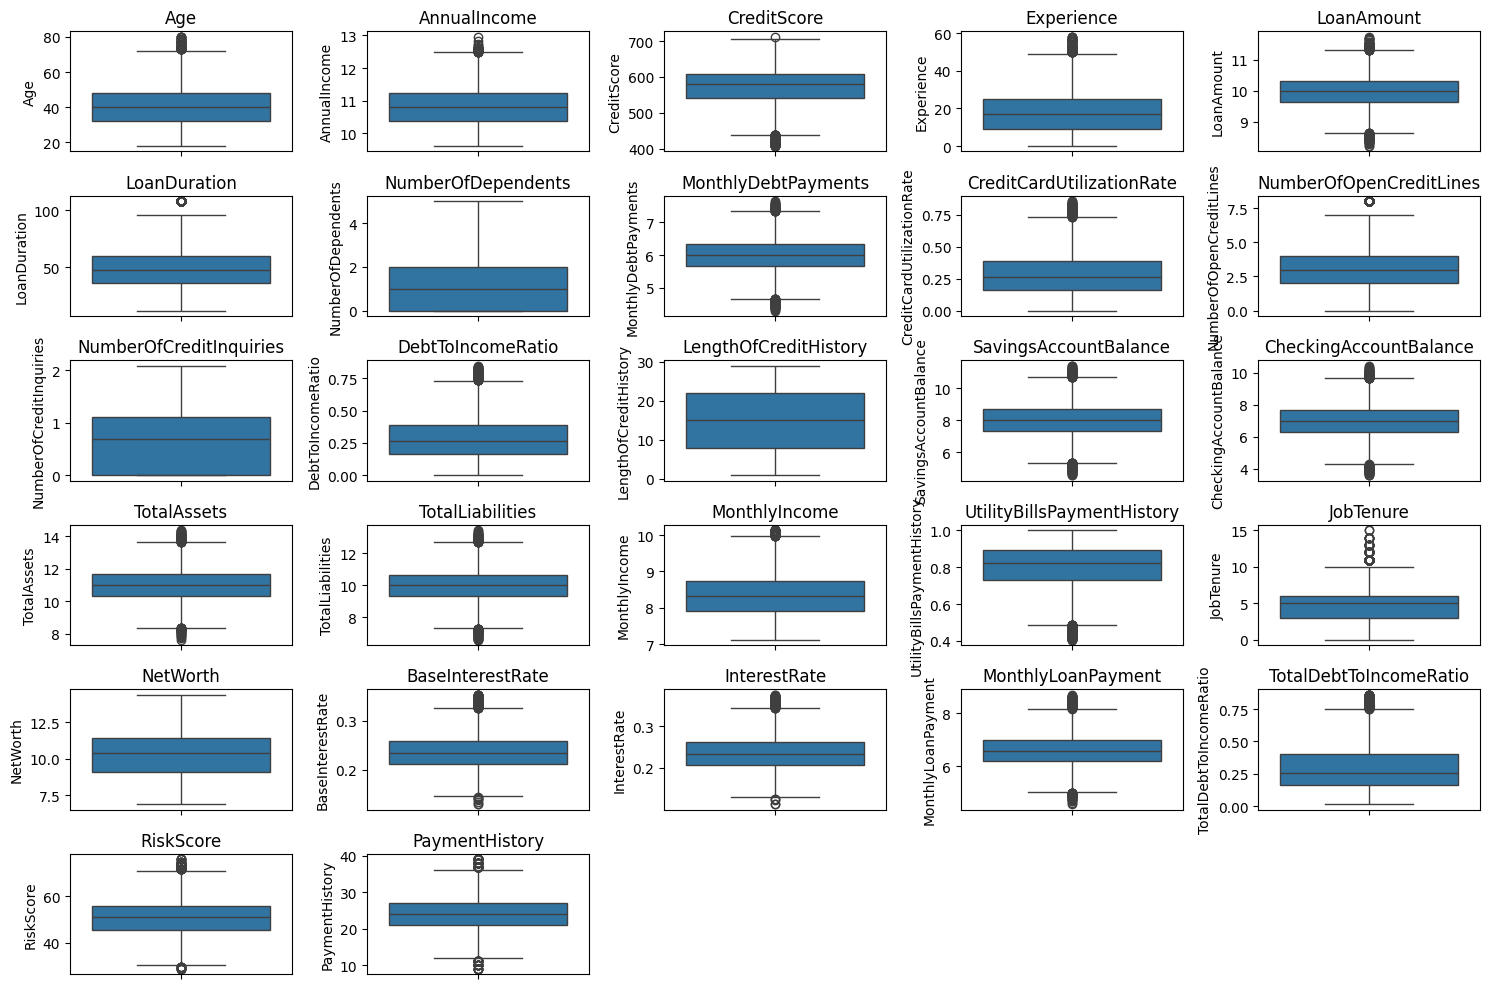

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 10))

# Create a boxplot for each continuous column
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)  # Create a 5x5 grid of subplots
    sns.boxplot(y=final_df[column])
    plt.title(column)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### IQR method to identify the remaining outliers

In [19]:

# Function to count outliers based on IQR
def count_outliers_iqr(final_df, column):
    Q1 = final_df[column].quantile(0.25)
    Q3 = final_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = final_df[(final_df[column] < lower_bound) | (final_df[column] > upper_bound)]
    return len(outliers)  # Return the count of outliers


# Count outliers for each continuous column and store the results
outlier_counts = {}
for column in continuous_columns:
    outlier_counts[column] = count_outliers_iqr(final_df, column)

# Display the count of outliers for each column
for column, count in outlier_counts.items():
    print(f'Count of outliers in {column}: {count}')

Count of outliers in Age: 56
Count of outliers in AnnualIncome: 58
Count of outliers in CreditScore: 182
Count of outliers in Experience: 68
Count of outliers in LoanAmount: 105
Count of outliers in LoanDuration: 459
Count of outliers in NumberOfDependents: 0
Count of outliers in MonthlyDebtPayments: 119
Count of outliers in CreditCardUtilizationRate: 119
Count of outliers in NumberOfOpenCreditLines: 164
Count of outliers in NumberOfCreditInquiries: 0
Count of outliers in DebtToIncomeRatio: 127
Count of outliers in LengthOfCreditHistory: 0
Count of outliers in SavingsAccountBalance: 148
Count of outliers in CheckingAccountBalance: 119
Count of outliers in TotalAssets: 90
Count of outliers in TotalLiabilities: 119
Count of outliers in MonthlyIncome: 59
Count of outliers in UtilityBillsPaymentHistory: 213
Count of outliers in JobTenure: 236
Count of outliers in NetWorth: 0
Count of outliers in BaseInterestRate: 128
Count of outliers in InterestRate: 134
Count of outliers in MonthlyLoanPa

In [20]:
print(final_df.shape)


(18648, 35)


In [21]:
final_df.reset_index(drop=True, inplace=True)


### Capping Outliers using IQR method

In [22]:
import pandas as pd

def handle_outliers(dataframe, lower_percentile=0.05, upper_percentile=0.95):
    """Handles outliers by capping them with the closest non-outlier value."""

    # Create a copy of the original DataFrame to hold cleaned data
    cleaned_df = final_df.copy()

    # Select continuous columns (numeric types)
    continuous_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns
    binary_cols = cleaned_df.select_dtypes(include=['int64']).columns  # Identify binary columns

    # Filter out binary columns from continuous columns
    continuous_cols = [col for col in continuous_cols if cleaned_df[col].nunique() > 2]

    # Initialize a counter for capped values
    capped_count = 0

    # IQR capping step
    for col in continuous_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]

        # Capping outliers with the closest non-outlier value
        for index in outliers.index:
            if cleaned_df[col].iloc[index] < lower_bound:
                # Find the closest non-outlier value above the lower bound
                closest_non_outlier = cleaned_df[cleaned_df[col] >= lower_bound]
                if not closest_non_outlier.empty:
                    cleaned_df.at[index, col] = closest_non_outlier[col].min()
                    capped_count += 1
            elif cleaned_df[col].iloc[index] > upper_bound:
                # Find the closest non-outlier value below the upper bound
                closest_non_outlier = cleaned_df[cleaned_df[col] <= upper_bound]
                if not closest_non_outlier.empty:
                    cleaned_df.at[index, col] = closest_non_outlier[col].max()
                    capped_count += 1

    return cleaned_df, capped_count

# Example usage
# Assuming 'final_df' is your original DataFrame
cleaned_df, capped_count = handle_outliers(final_df)

# Check the resulting DataFrame
print(cleaned_df.head())
print("Dataset shape after cleaning:", cleaned_df.shape)
print("Number of capped values:", capped_count)


   AnnualIncome  LoanAmount  MonthlyDebtPayments  NumberOfCreditInquiries  \
0     10.595359    9.484405             5.214936                 1.098612   
1     10.589358   10.167619             6.208590                 1.386294   
2     10.614597    9.777244             6.805723                 0.000000   
3     11.143093   10.542680             6.628041                 0.693147   
4     11.545054    9.125327             5.616771                 0.000000   

   SavingsAccountBalance  CheckingAccountBalance  TotalAssets  \
0               8.940236                7.092574    11.892129   
1               8.439880                8.149313    10.881908   
2               6.787845                6.797940    10.133686   
3               7.424165                7.104965    11.560028   
4               7.349874                8.513587    12.406177   

   TotalLiabilities  MonthlyIncome   NetWorth  ...  LoanApproved  \
0          9.861832       8.110728  11.751383  ...             0   
1         

after using modified Z-score method to identify and remove extreme outliers, which is particularly effective for skewed datasets due to its reliance on the median and median absolute deviation (MAD), thus mitigating the influence of extreme values and reducing the risk of misrepresentation. and then used capping method to address remaining outliers identified through the interquartile range (IQR) approach, capping them to their nearest non-outlier values instead of discarding them, thereby preserving valuable information and maintaining the overall distribution while minimizing the influence of outliers

### Visualize using box plot after handling outliers using IQR method

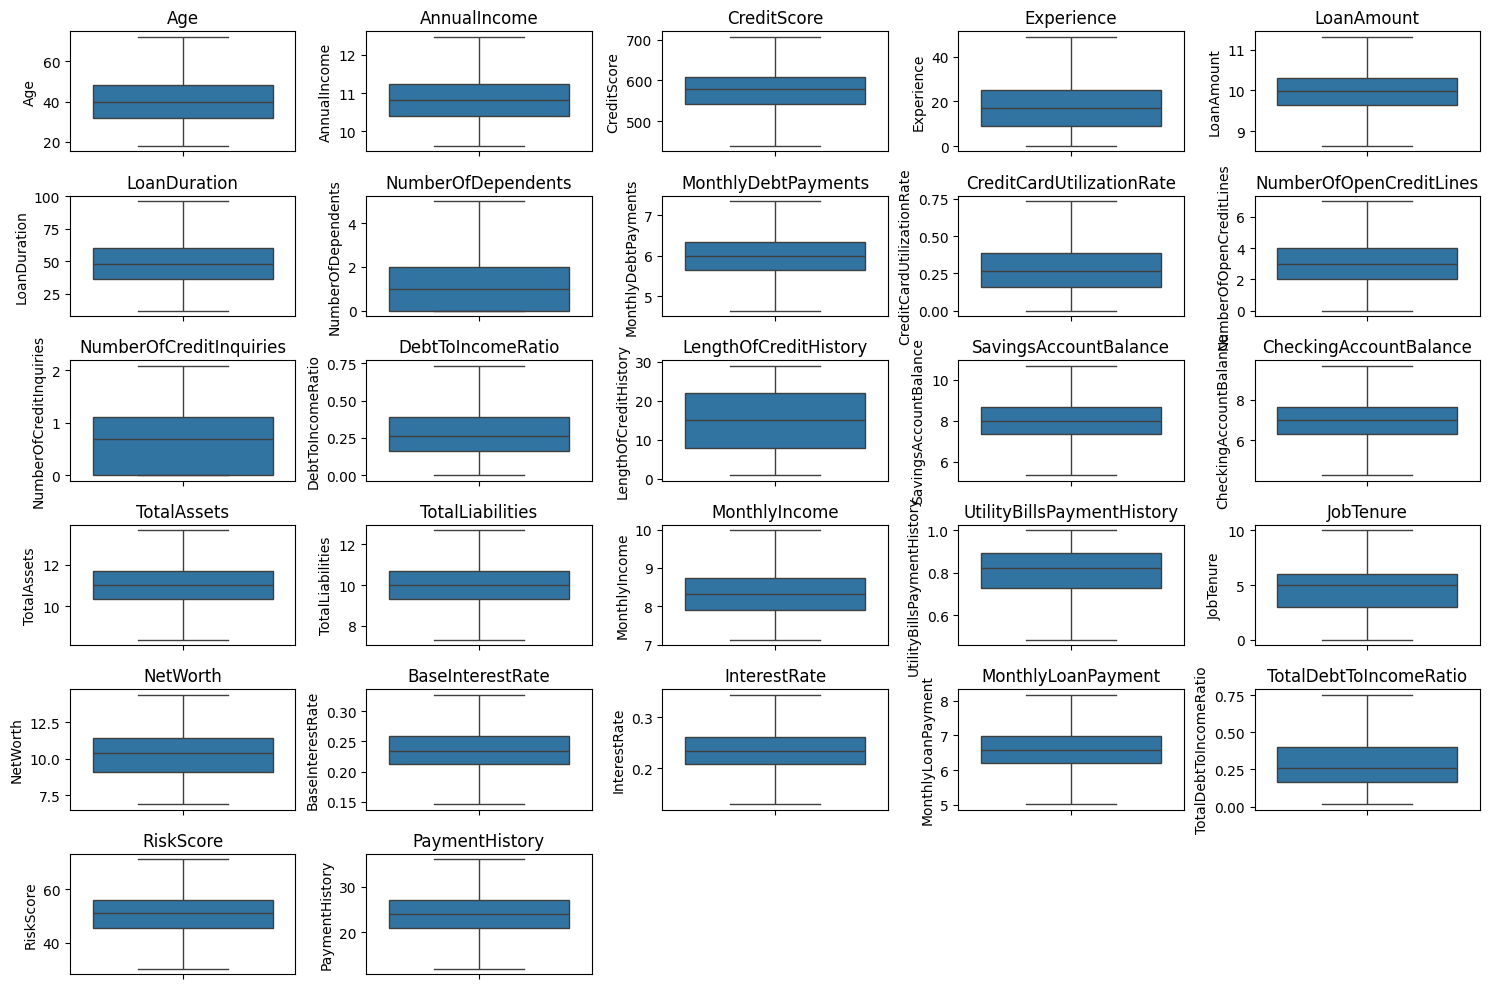

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 10))

# Create a boxplot for each continuous column
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)  # Create a 5x5 grid of subplots
    sns.boxplot(y=cleaned_df[column])
    plt.title(column)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

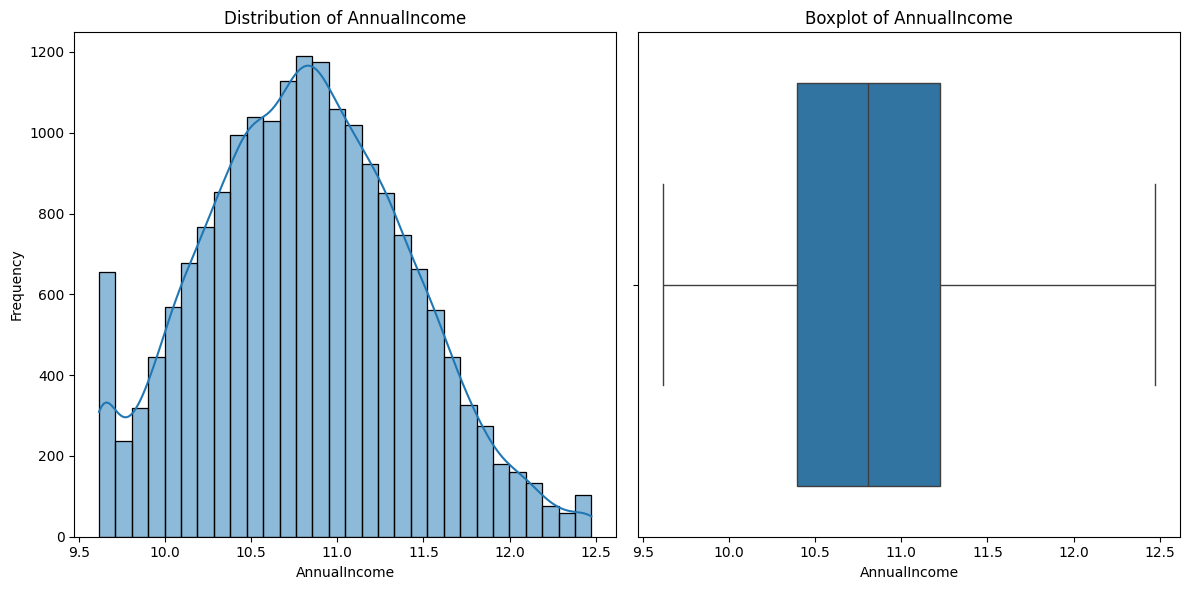

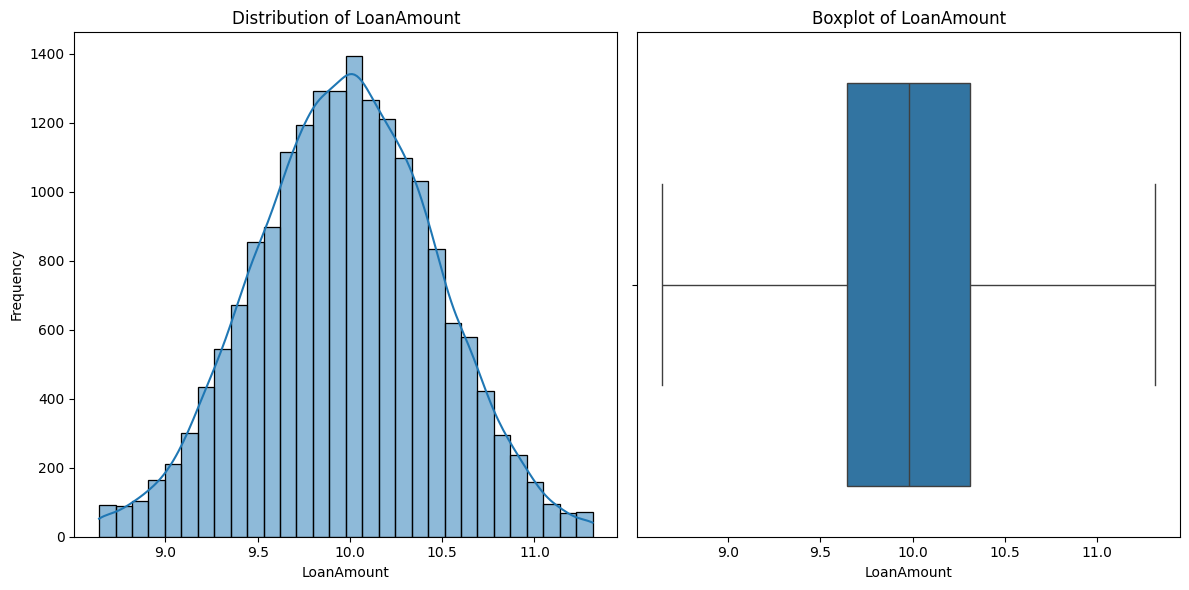

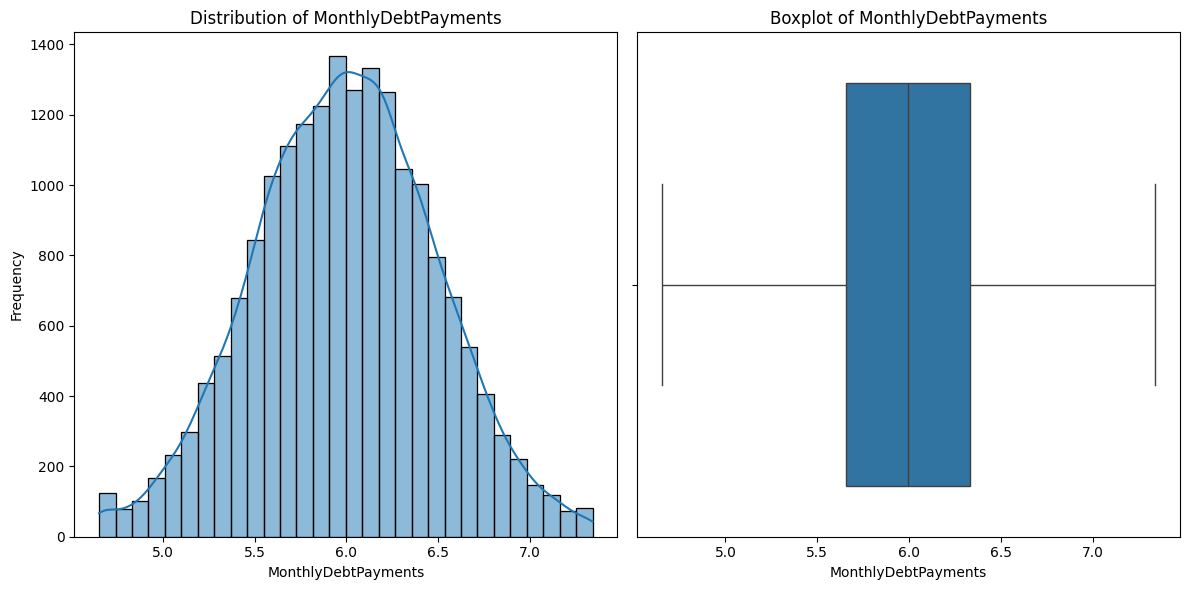

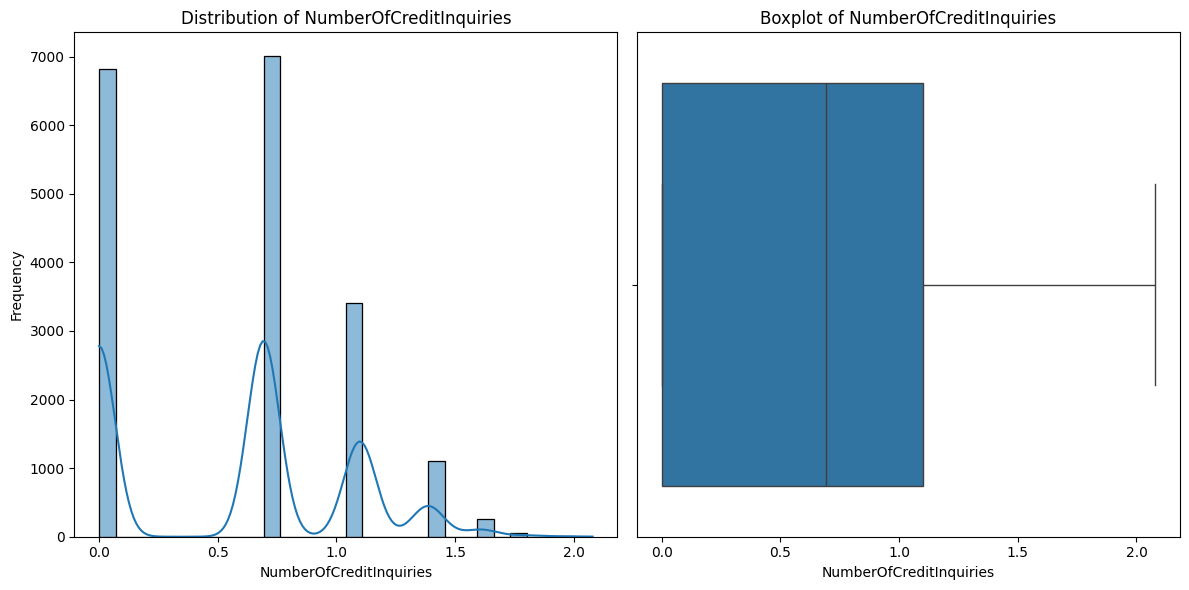

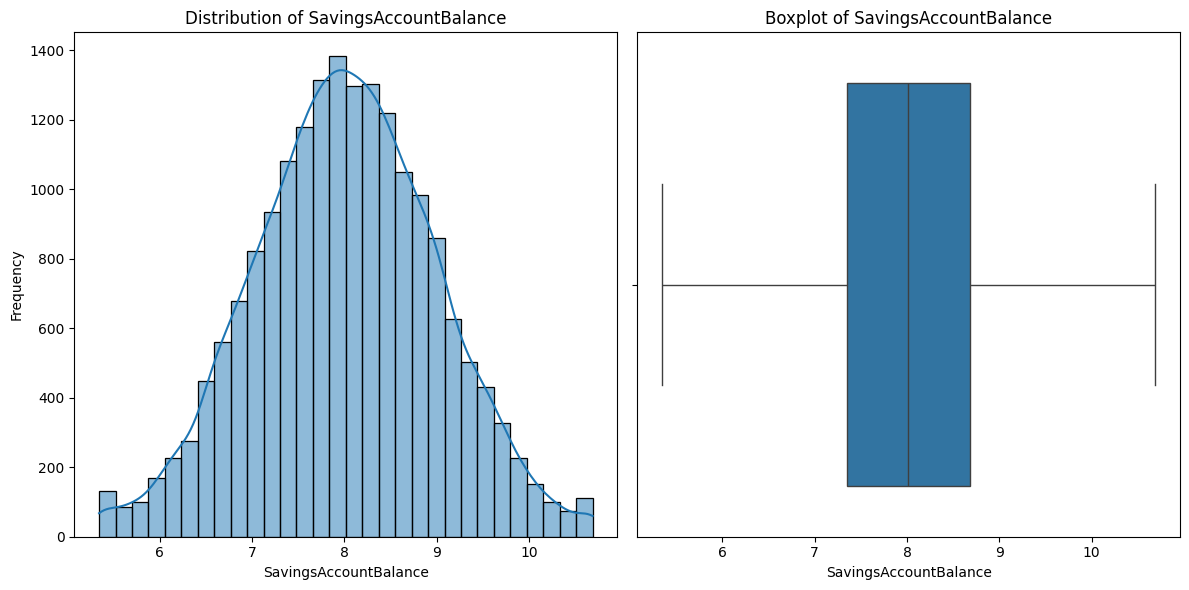

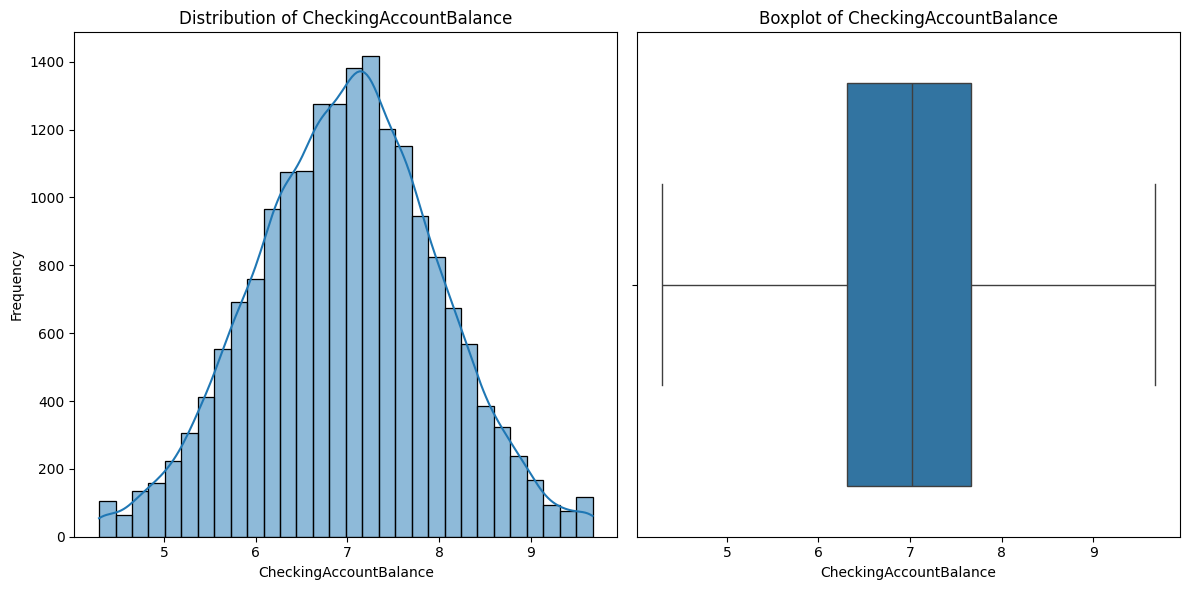

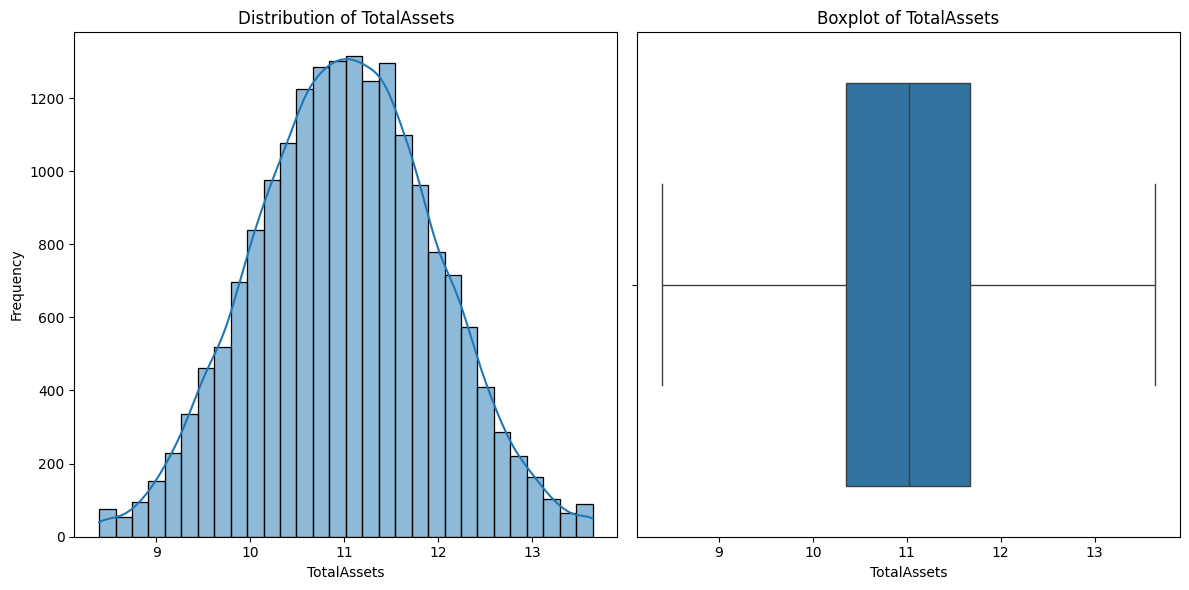

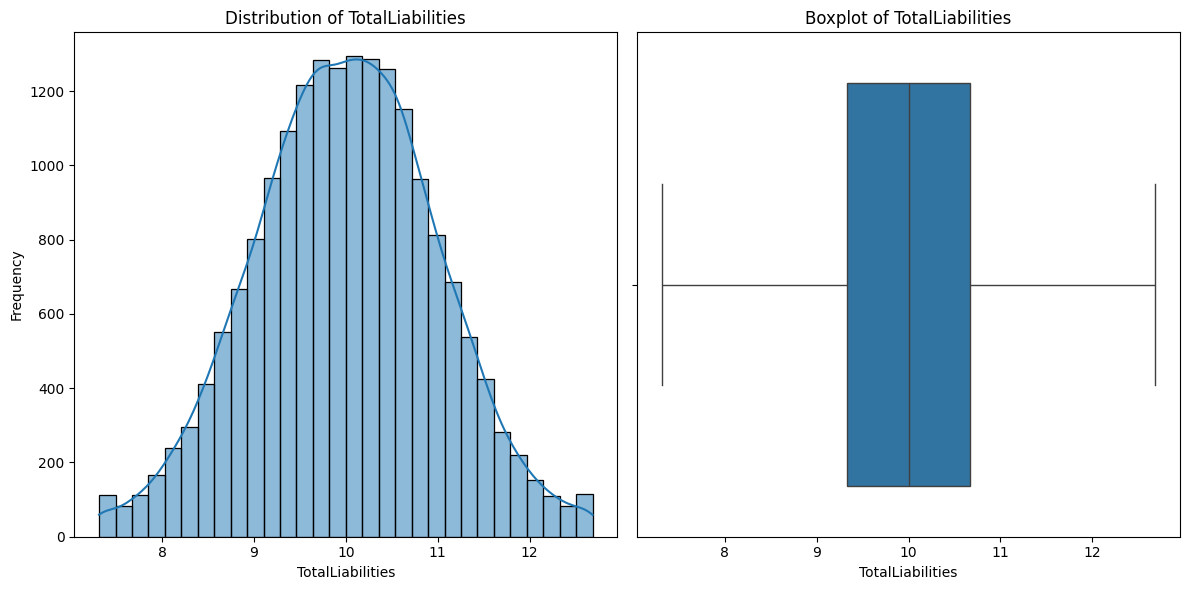

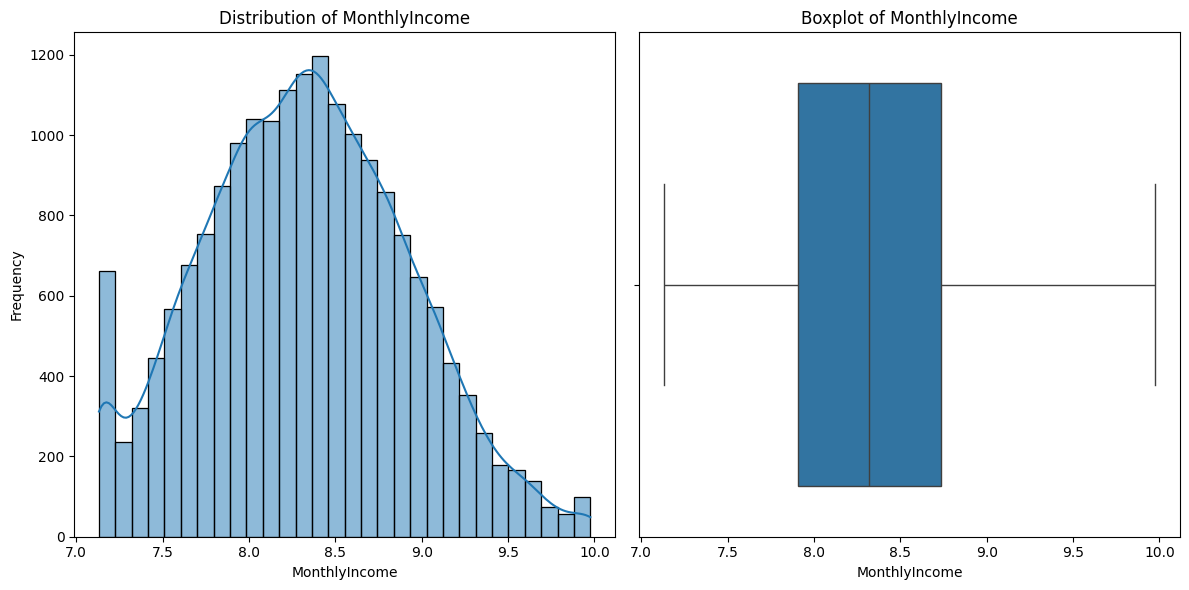

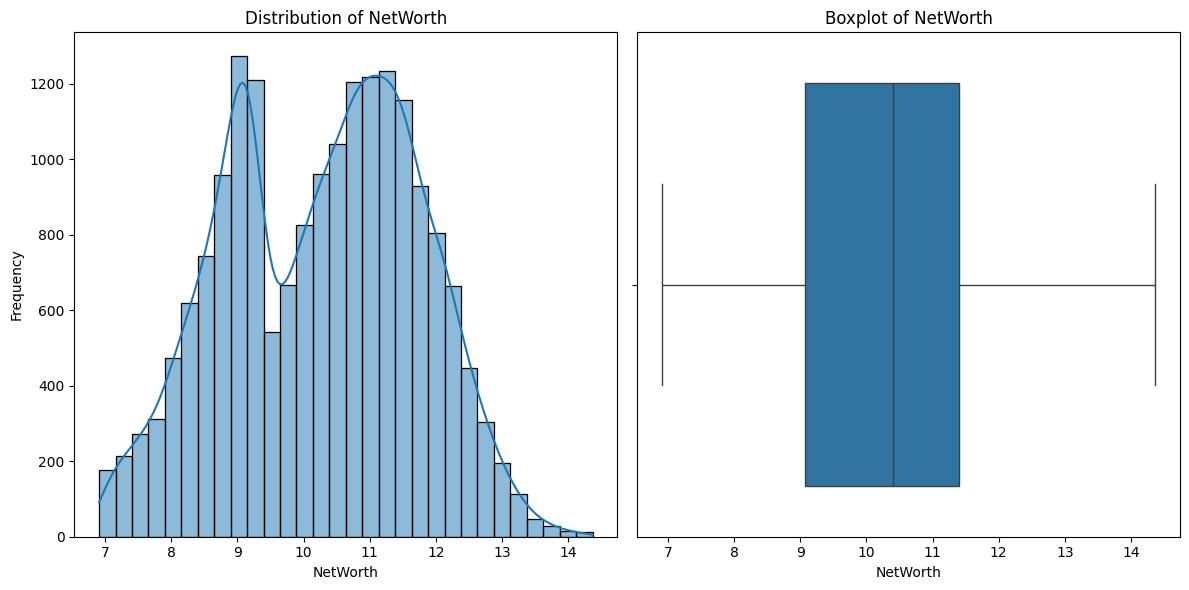

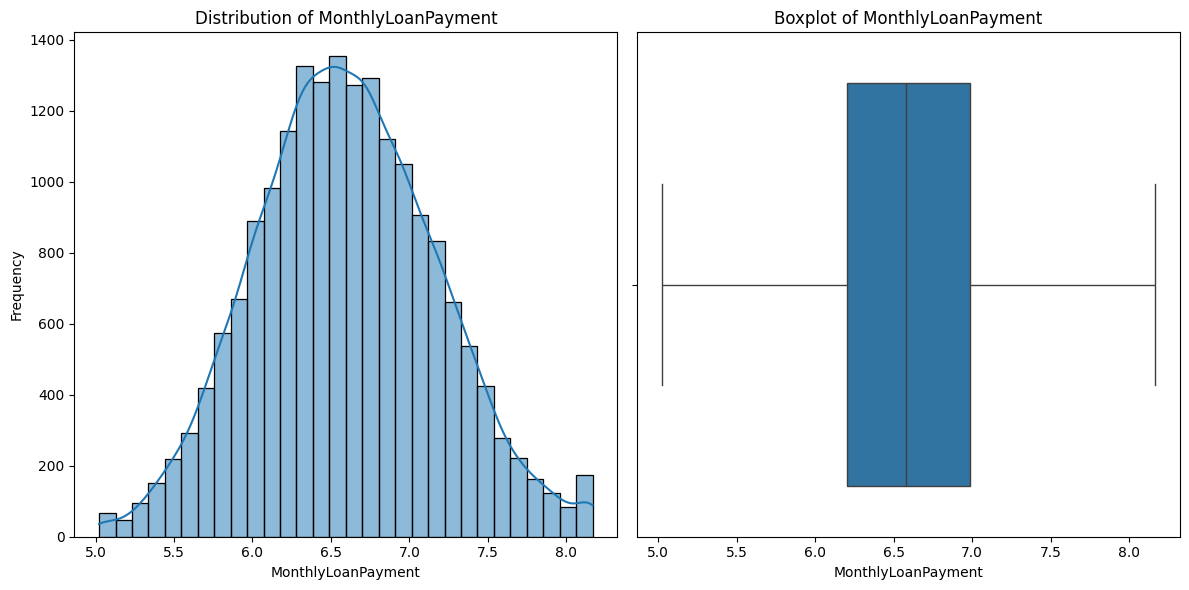

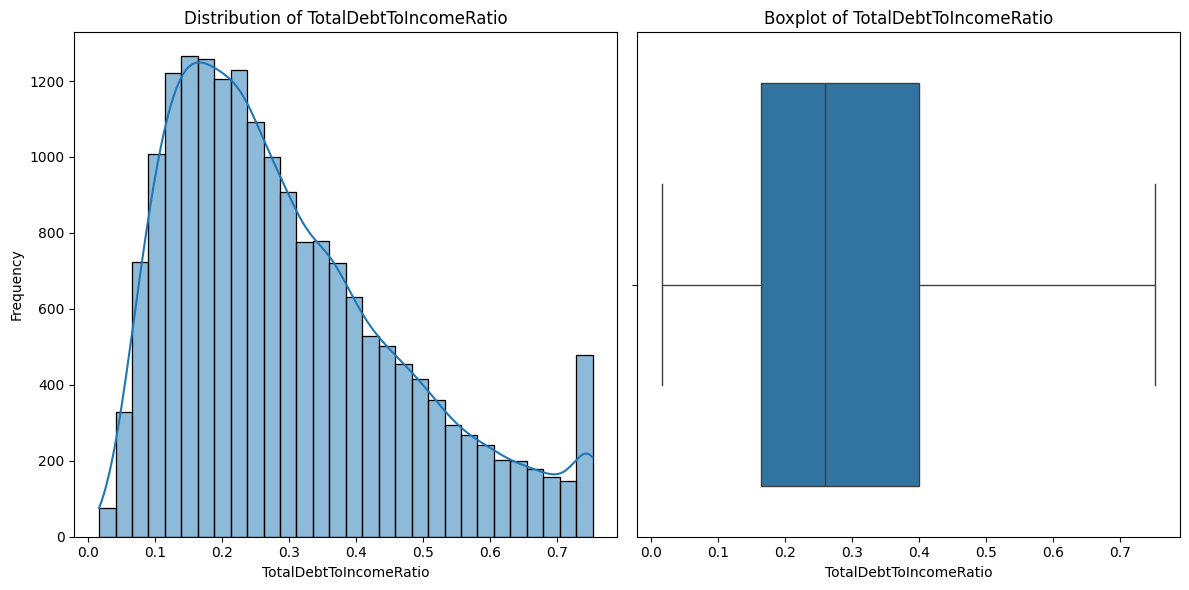

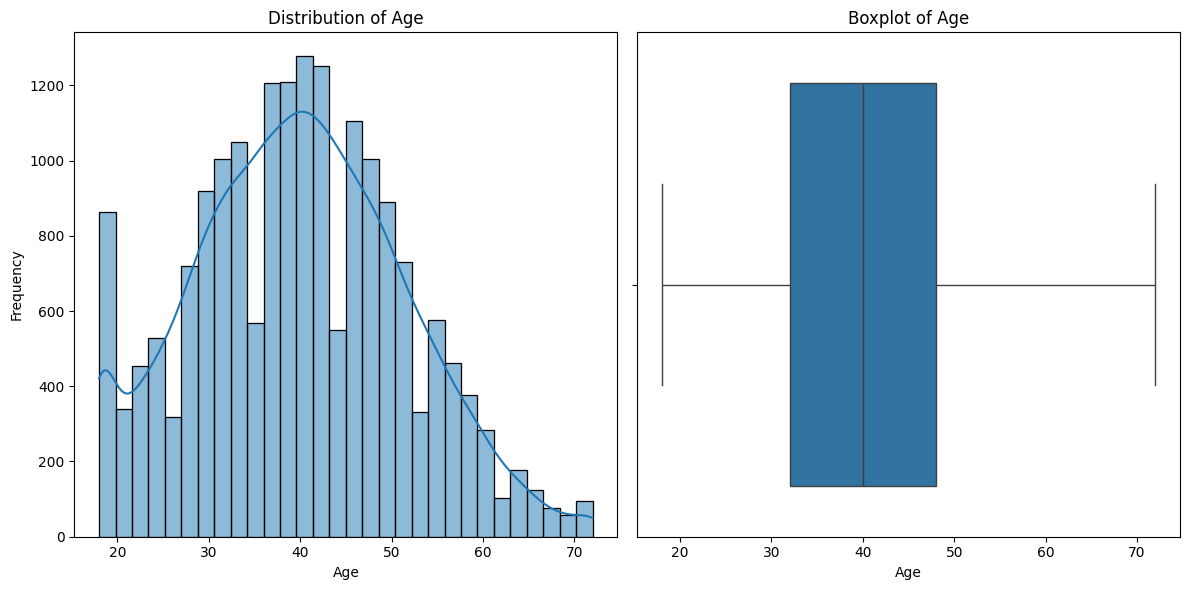

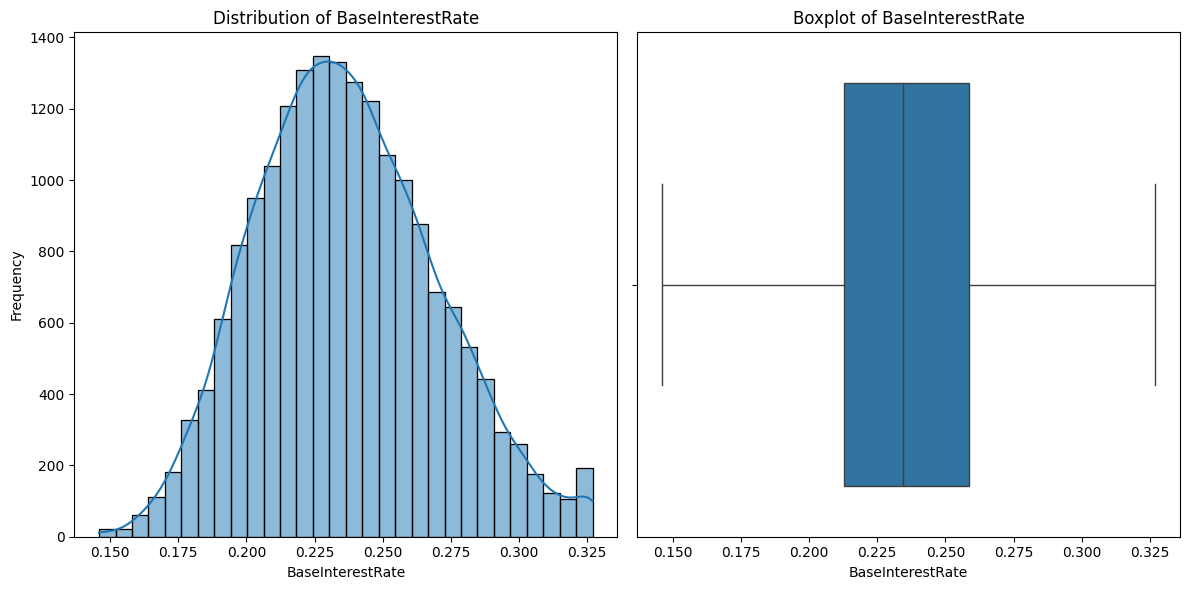

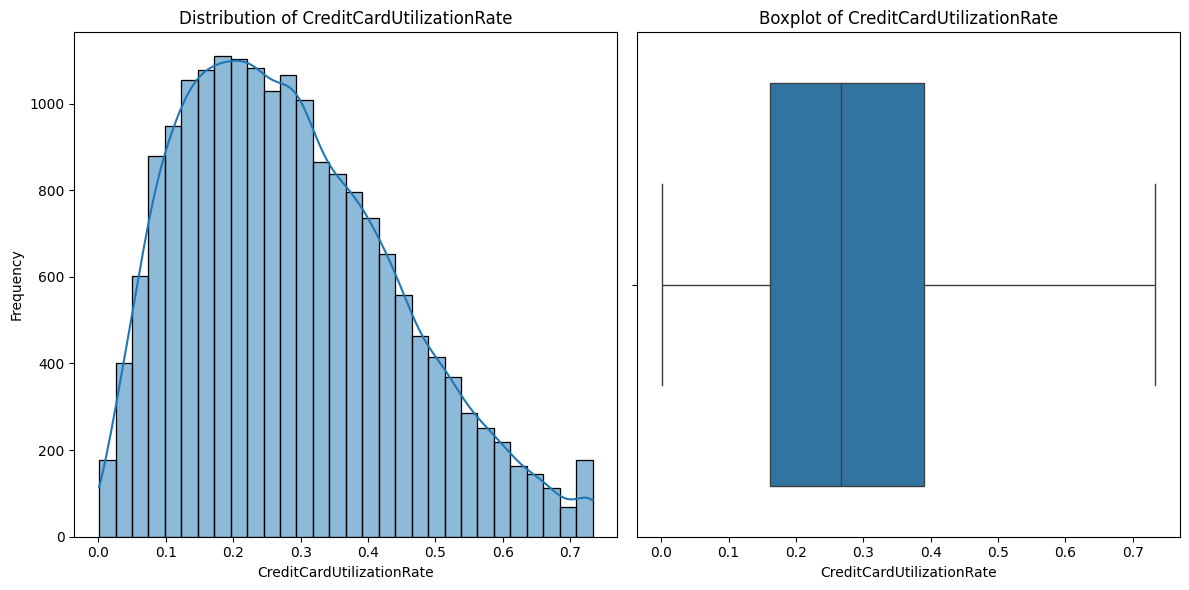

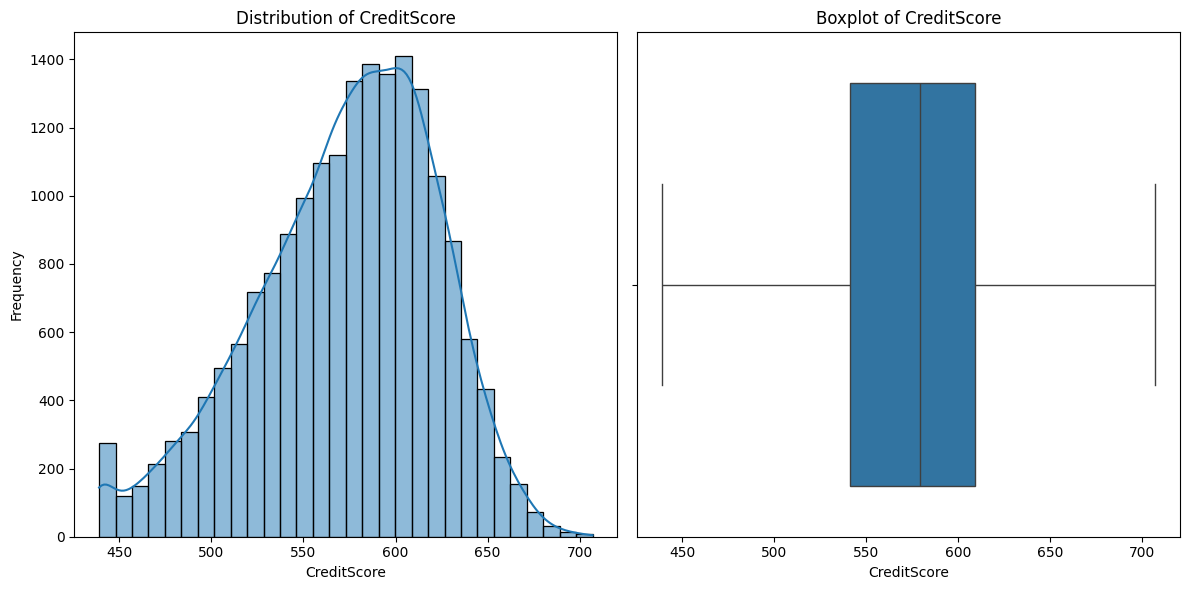

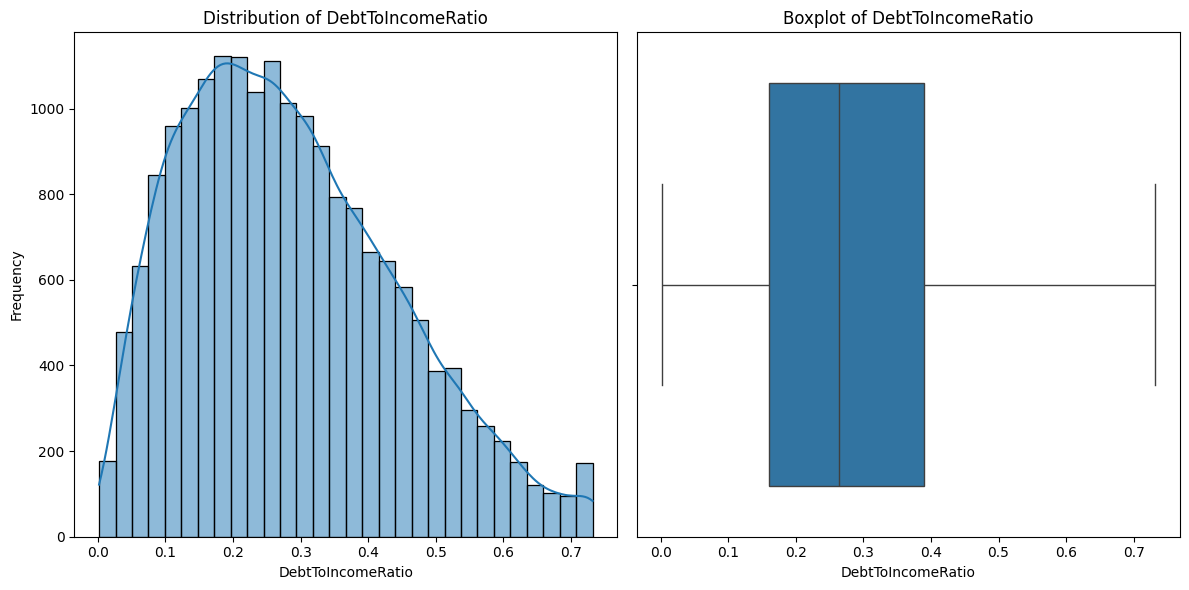

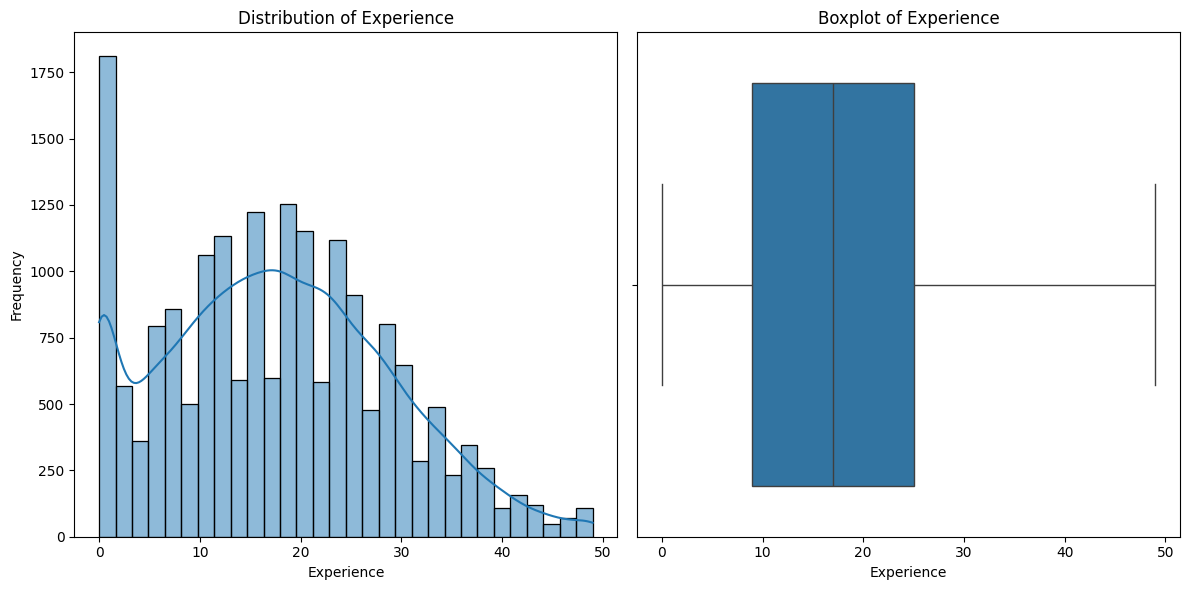

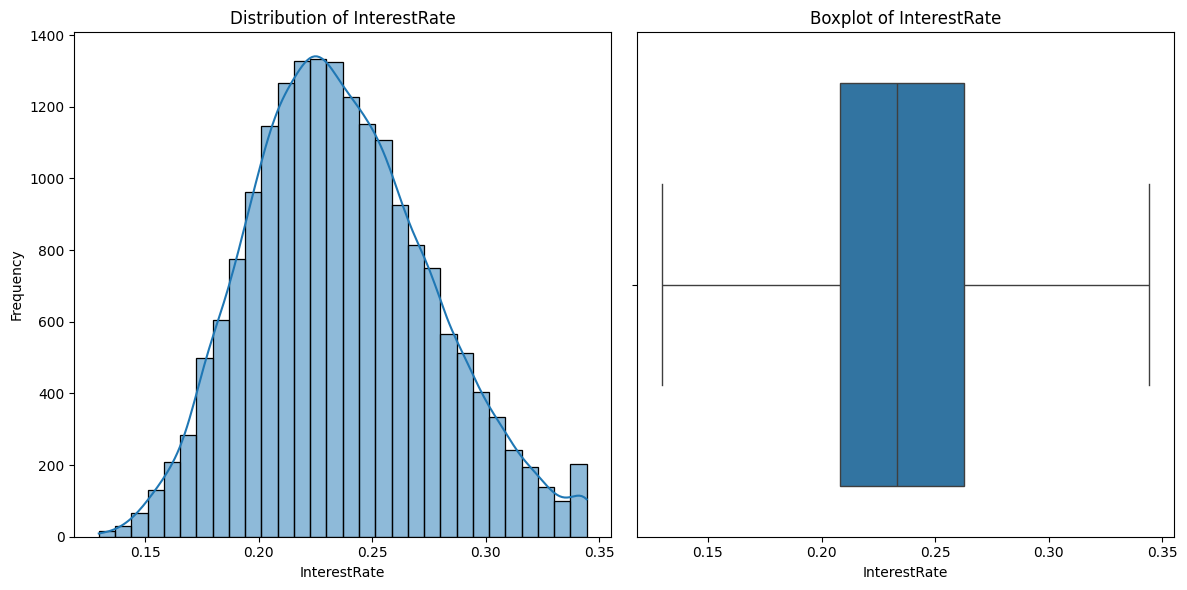

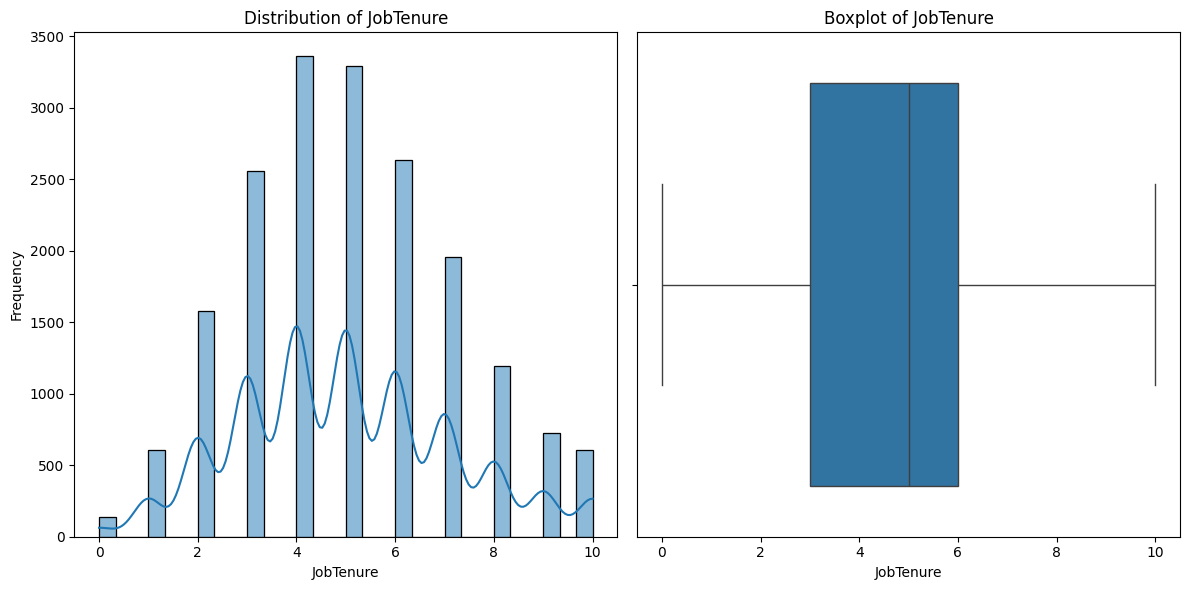

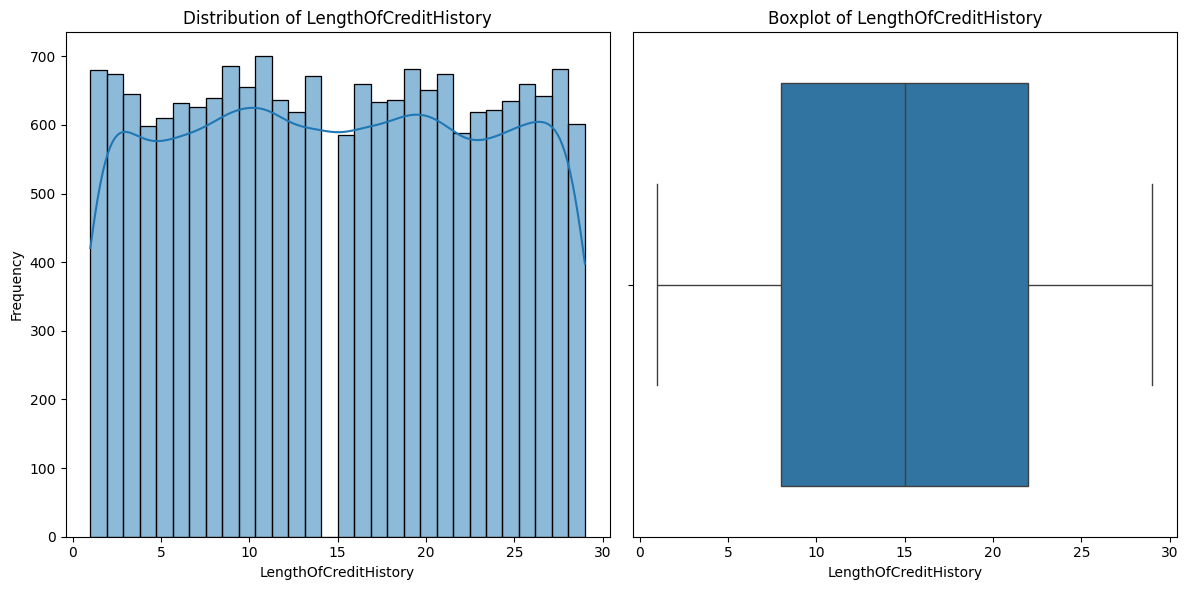

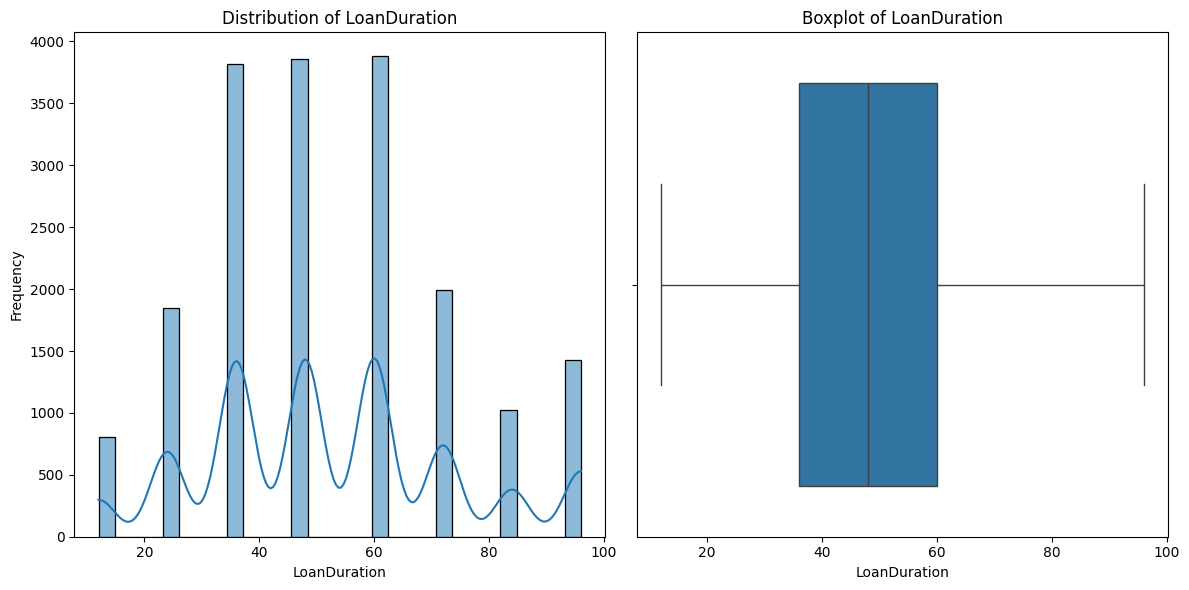

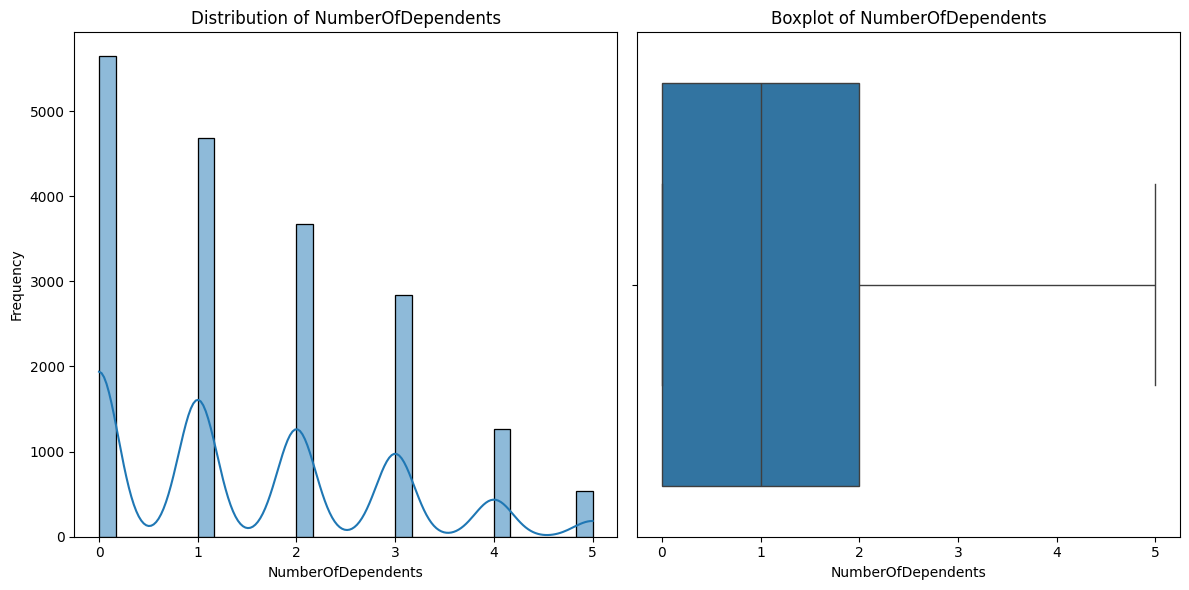

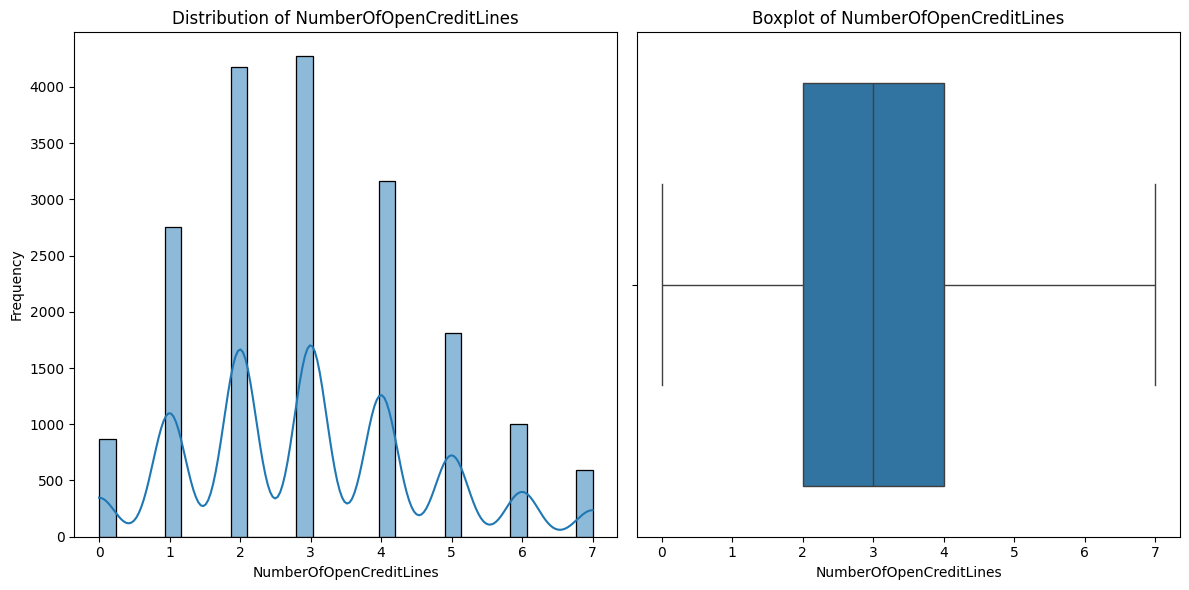

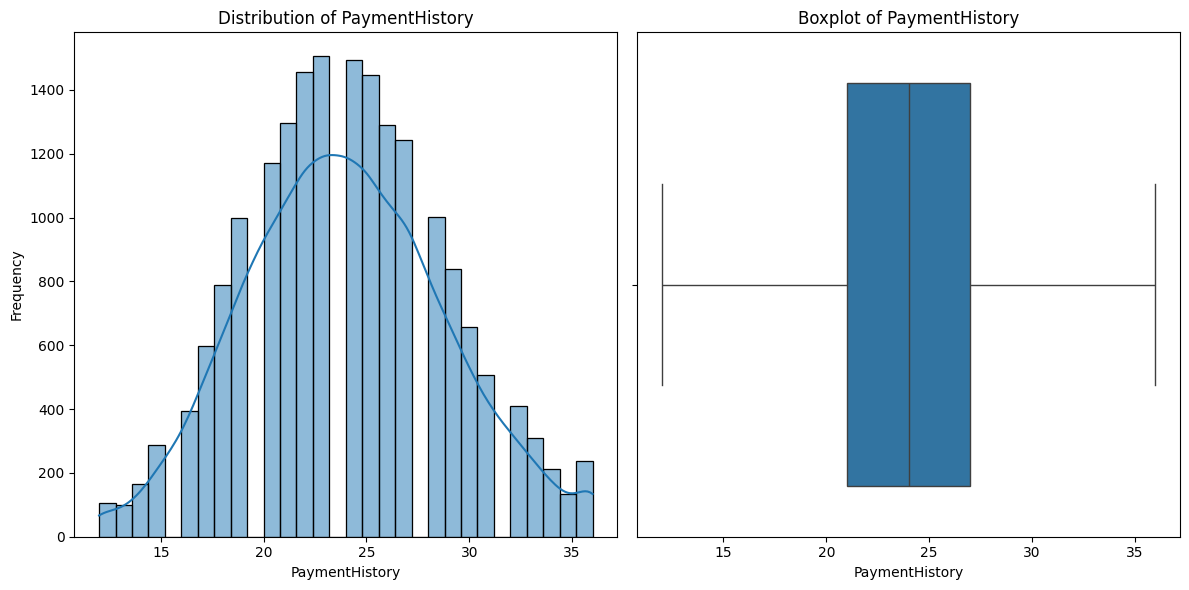

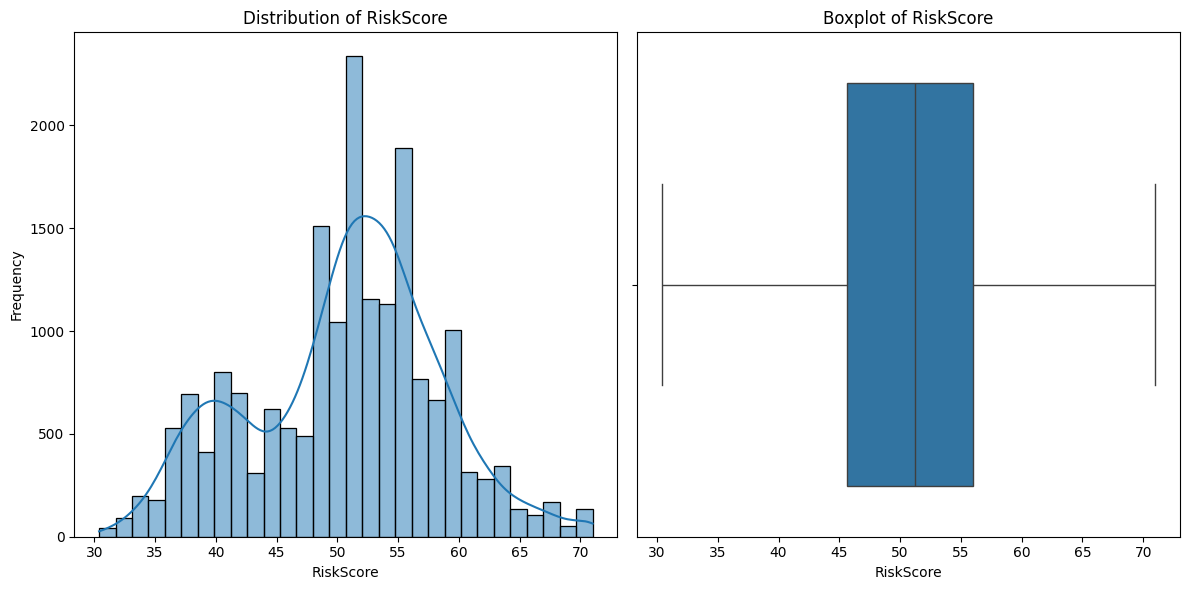

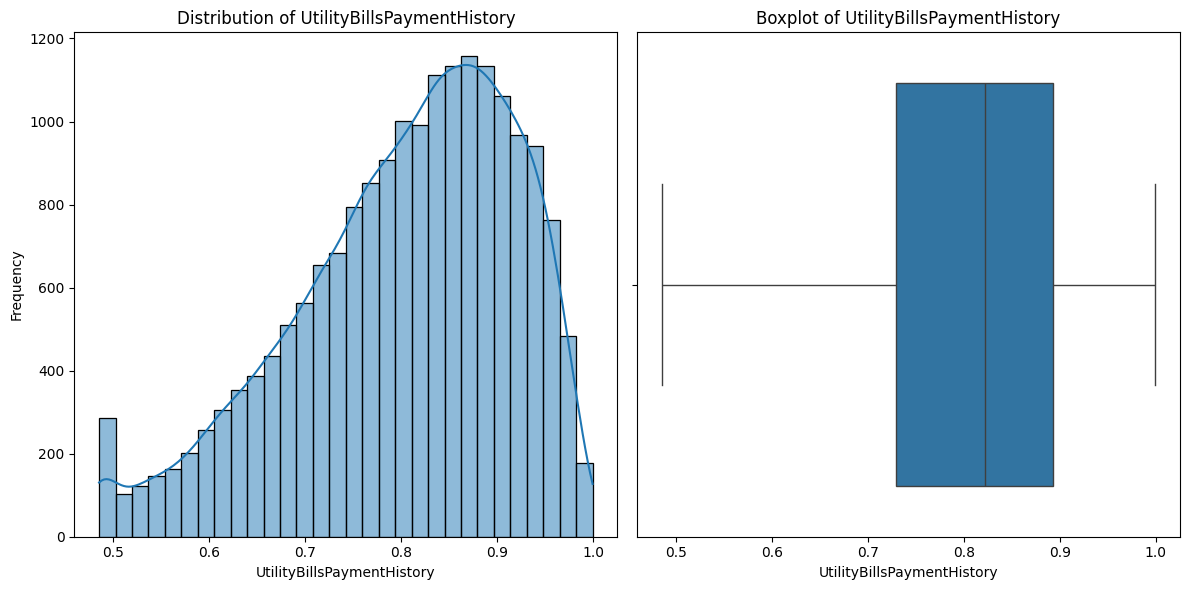

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def check_binary_columns(dataframe):
    """Check for binary columns (0 and 1 only) in the DataFrame."""
    binary_columns = []
    for column in dataframe.select_dtypes(include=['int64', 'uint8']):
        unique_values = dataframe[column].unique()
        if set(unique_values) <= {0, 1}:
            binary_columns.append(column)
    return binary_columns

def visualize_column_distribution(dataframe, column_name):
    """Visualize the distribution of a specified column with histogram and boxplot."""
    plt.figure(figsize=(12, 6))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(dataframe[column_name], bins=30, kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=dataframe[column_name])
    plt.title(f'Boxplot of {column_name}')

    plt.tight_layout()
    plt.show()

# Get numerical columns from the DataFrame
numerical_columns = cleaned_df.select_dtypes(include=['float64', 'int64']).columns

# Identify binary columns
binary_columns = check_binary_columns(cleaned_df)

# Filter out binary columns from numerical columns
filtered_numerical_columns = [col for col in numerical_columns if col not in binary_columns]

# Iterate over each numerical column (excluding binary) and visualize
for column in filtered_numerical_columns:
    visualize_column_distribution(cleaned_df, column)


## **Encoding categorical variables**

In [25]:
import pandas as pd

# Custom mapping for education levels
education_mapping = {
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate': 4
}

# Apply the mapping directly to the EducationLevel column in cleaned_df
cleaned_df['EducationLevel_Encoded'] = cleaned_df['EducationLevel'].map(education_mapping)

# Print the education mapping
print("Education Level Mapping:", education_mapping)

# List of categorical columns to be one-hot encoded
categorical_columns = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus']

# Perform one-hot encoding and ensure all categories are included
df_one_hot = pd.get_dummies(cleaned_df[categorical_columns], drop_first=False)  # Keep all categories

# Combine the one-hot encoded columns with the cleaned DataFrame, excluding the original categorical columns
cleaned_df = pd.concat([cleaned_df.drop(columns=categorical_columns + ['EducationLevel']), df_one_hot], axis=1)

# Display the final DataFrame
print(cleaned_df.head())


Education Level Mapping: {'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
   AnnualIncome  LoanAmount  MonthlyDebtPayments  NumberOfCreditInquiries  \
0     10.595359    9.484405             5.214936                 1.098612   
1     10.589358   10.167619             6.208590                 1.386294   
2     10.614597    9.777244             6.805723                 0.000000   
3     11.143093   10.542680             6.628041                 0.693147   
4     11.545054    9.125327             5.616771                 0.000000   

   SavingsAccountBalance  CheckingAccountBalance  TotalAssets  \
0               8.940236                7.092574    11.892129   
1               8.439880                8.149313    10.881908   
2               6.787845                6.797940    10.133686   
3               7.424165                7.104965    11.560028   
4               7.349874                8.513587    12.406177   

   TotalLiabilities  MonthlyIncome   NetWo

### Convert Boolean type to numerical

Convert boolean to numeric as algorithms like XGBoost, Random Forest, and Gradient Boosting require numeric values for processing and computations. replace "YES" with 1 and "NO" with 0

In [27]:
import pandas as pd


# List of boolean columns to convert to numeric
boolean_columns = [
    'MaritalStatus_Divorced',
    'MaritalStatus_Married',
    'MaritalStatus_Single',
    'MaritalStatus_Widowed',
    'HomeOwnershipStatus_Mortgage',
    'HomeOwnershipStatus_Other',
    'HomeOwnershipStatus_Own',
    'HomeOwnershipStatus_Rent',
    'LoanPurpose_Auto',
    'LoanPurpose_Debt Consolidation',
    'LoanPurpose_Education',
    'LoanPurpose_Home',
    'LoanPurpose_Other',
    'EmploymentStatus_Employed',
    'EmploymentStatus_Self-Employed',
    'EmploymentStatus_Unemployed'
]

# Convert boolean columns to numeric
cleaned_df[boolean_columns] = cleaned_df[boolean_columns].astype(int)

# Display the updated DataFrame info
print(cleaned_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18648 entries, 0 to 18647
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AnnualIncome                    18648 non-null  float64
 1   LoanAmount                      18648 non-null  float64
 2   MonthlyDebtPayments             18648 non-null  float64
 3   NumberOfCreditInquiries         18648 non-null  float64
 4   SavingsAccountBalance           18648 non-null  float64
 5   CheckingAccountBalance          18648 non-null  float64
 6   TotalAssets                     18648 non-null  float64
 7   TotalLiabilities                18648 non-null  float64
 8   MonthlyIncome                   18648 non-null  float64
 9   NetWorth                        18648 non-null  float64
 10  MonthlyLoanPayment              18648 non-null  float64
 11  TotalDebtToIncomeRatio          18648 non-null  float64
 12  Age                             

In [28]:
import pandas as pd

# Assuming cleaned_df is your DataFrame
# Identify binary columns
binary_columns = []

for column in cleaned_df.columns:
    if cleaned_df[column].nunique() == 2 and cleaned_df[column].dtype in ['int64', 'float64']:
        binary_columns.append(column)

# Display the identified binary columns
print("Binary columns:", binary_columns)


Binary columns: ['BankruptcyHistory', 'LoanApproved', 'PreviousLoanDefaults', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widowed', 'HomeOwnershipStatus_Mortgage', 'HomeOwnershipStatus_Other', 'HomeOwnershipStatus_Own', 'HomeOwnershipStatus_Rent', 'LoanPurpose_Auto', 'LoanPurpose_Debt Consolidation', 'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other', 'EmploymentStatus_Employed', 'EmploymentStatus_Self-Employed', 'EmploymentStatus_Unemployed']


# **Scaling the data**

## Min-Max scaling

In [29]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming cleaned_df is your DataFrame
# Identify numerical features excluding binary columns
# Adjust this list according to your actual column names
numerical_features = cleaned_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define binary columns (this is just an example, adjust accordingly)
exclude_columns = ['BankruptcyHistory', 'LoanApproved', 'PreviousLoanDefaults', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single',
                   'MaritalStatus_Widowed',  'HomeOwnershipStatus_Mortgage', 'HomeOwnershipStatus_Other', 'HomeOwnershipStatus_Own', 'HomeOwnershipStatus_Rent',
                   'LoanPurpose_Auto', 'LoanPurpose_Debt Consolidation', 'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other',
                  'EmploymentStatus_Employed', 'EmploymentStatus_Self-Employed', 'EmploymentStatus_Unemployed','EducationLevel_Encoded']

# Remove binary columns from numerical features for scaling
features_to_scale = [feature for feature in numerical_features if feature not in exclude_columns]

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Fit and transform the selected features
cleaned_df[features_to_scale] = scaler.fit_transform(cleaned_df[features_to_scale])

# Verify the result
print(cleaned_df[features_to_scale].head())


   AnnualIncome  LoanAmount  MonthlyDebtPayments  NumberOfCreditInquiries  \
0      0.342549    0.315475             0.208834                 0.528321   
1      0.340450    0.570925             0.578741                 0.666667   
2      0.349277    0.424966             0.801035                 0.000000   
3      0.534104    0.711157             0.734890                 0.333333   
4      0.674679    0.181218             0.358425                 0.000000   

   SavingsAccountBalance  CheckingAccountBalance  TotalAssets  \
0               0.672594                0.520410     0.666151   
1               0.579057                0.716669     0.473954   
2               0.270225                0.465691     0.331603   
3               0.389179                0.522712     0.602968   
4               0.375291                0.784322     0.763950   

   TotalLiabilities  MonthlyIncome  NetWorth  ...  Experience  InterestRate  \
0          0.474236       0.344120  0.649246  ...    0.448980      

In [30]:
cleaned_df.head()

AnnualIncome  LoanAmount  MonthlyDebtPayments  NumberOfCreditInquiries  \
0      0.342549    0.315475             0.208834                 0.528321   
1      0.340450    0.570925             0.578741                 0.666667   
2      0.349277    0.424966             0.801035                 0.000000   
3      0.534104    0.711157             0.734890                 0.333333   
4      0.674679    0.181218             0.358425                 0.000000   

   SavingsAccountBalance  CheckingAccountBalance  TotalAssets  \
0               0.672594                0.520410     0.666151   
1               0.579057                0.716669     0.473954   
2               0.270225                0.465691     0.331603   
3               0.389179                0.522712     0.602968   
4               0.375291                0.784322     0.763950   

   TotalLiabilities  MonthlyIncome  NetWorth  ...  HomeOwnershipStatus_Own  \
0          0.474236       0.344120  0.649246  ...                        1   
1          0.345234       0.342012  0.506014  ...                        0   
2          0.828946       0.350881  0.221054  ...                        0   
3          0.237163       0.536603  0.616541  ...                        0   
4          0.454846       0.677870  0.727195  ...                        0   

   HomeOwnershipStatus_Rent  LoanPurpose_Auto  LoanPurpose_Debt Consolidation  \
0                         0                 0                               0   
1                         0                 0                               1   
2                         1                 0                               0   
3                         0                 0                               0   
4                         0                 0                               1   

   LoanPurpose_Education  LoanPurpose_Home  LoanPurpose_Other  \
0                      0                 1                  0   
1                      0                 0                  0   
2                      1                 0                  0   
3                      0                 1                  0   
4                      0                 0                  0   

   EmploymentStatus_Employed  EmploymentStatus_Self-Employed  \
0                          1                               0   
1                          1                               0   
2                          1                               0   
3                          1                               0   
4                          1                               0   

   EmploymentStatus_Unemployed  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  

[5 rows x 47 columns]

In [31]:
# Check for negative values in the scaled features
negative_values = cleaned_df[features_to_scale] < 0

# Get columns that have negative values
columns_with_negatives = negative_values.any()

# Display columns with negative values if any
neg_columns = columns_with_negatives[columns_with_negatives].index.tolist()

if neg_columns:
    print(f"Columns with negative values after scaling: {neg_columns}")
else:
    print("No negative values found after scaling.")


No negative values found after scaling.


applied Min-Max scaling to the dataset, excluding binary columns, to ensure that all attribute values are transformed into a range between 0 and 1, effectively avoiding any negative values. This approach is particularly important for attributes that cannot assume negative values (ex: age)


## **Checking Significance features**

In [32]:
# Define numerical features
numerical_features = [
    'Age', 'AnnualIncome', 'CreditScore', 'Experience', 'LoanAmount',
    'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments',
    'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
    'DebtToIncomeRatio', 'LengthOfCreditHistory', 'SavingsAccountBalance',
    'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome',
    'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate',
    'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'RiskScore'
]

# Define categorical features including binary and encoded variables
categorical_features = [
    'BankruptcyHistory', 'LoanApproved', 'PreviousLoanDefaults', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widowed',
     'HomeOwnershipStatus_Mortgage', 'HomeOwnershipStatus_Other', 'HomeOwnershipStatus_Own', 'HomeOwnershipStatus_Rent', 'LoanPurpose_Auto', 'LoanPurpose_Debt Consolidation',
     'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other','EmploymentStatus_Employed', 'EmploymentStatus_Self-Employed', 'EmploymentStatus_Unemployed',
     'EducationLevel_Encoded']


### T-Test for Evaluating Significance of Numerical Features

In [33]:
t_test_results = {}
for column in numerical_features:
    approved_group = cleaned_df[cleaned_df['LoanApproved'] == 1][column]
    not_approved_group = cleaned_df[cleaned_df['LoanApproved'] == 0][column]

    # Check if both groups are not empty before performing t-test
    if len(approved_group) > 0 and len(not_approved_group) > 0:
        t_stat, p_value = stats.ttest_ind(approved_group, not_approved_group, equal_var=False)
        t_test_results[column] = {'t-statistic': t_stat, 'p-value': p_value}

# Display the results
t_test_results_df = pd.DataFrame(t_test_results).T
print(t_test_results_df)

                            t-statistic        p-value
Age                           20.021197   3.884647e-87
AnnualIncome                 101.027298   0.000000e+00
CreditScore                   19.049649   3.716199e-79
Experience                    19.790802   3.382498e-85
LoanAmount                   -37.592630  1.869924e-286
LoanDuration                 -13.692848   3.094500e-42
NumberOfDependents             0.457727   6.471615e-01
MonthlyDebtPayments           -9.504619   2.603574e-21
CreditCardUtilizationRate     -1.603728   1.088137e-01
NumberOfOpenCreditLines       -0.988899   3.227429e-01
NumberOfCreditInquiries       -0.948631   3.428375e-01
DebtToIncomeRatio              0.127127   8.988429e-01
LengthOfCreditHistory         15.174689   2.685467e-51
SavingsAccountBalance          0.833840   4.043961e-01
CheckingAccountBalance         1.372470   1.699558e-01
TotalAssets                   18.753305   1.258986e-76
TotalLiabilities              -4.656257   3.271793e-06
MonthlyInc

### Chi-Square Test for Evaluating Significance of  Categorical Features

In [34]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [35]:
chi_square_results = {}

# Perform the chi-square test on each categorical column
for column in categorical_features:
    if column in cleaned_df.columns:  # Check if the column exists
        contingency_table = pd.crosstab(cleaned_df[column], cleaned_df['LoanApproved'])
        chi2, p, _, _ = stats.chi2_contingency(contingency_table)
        chi_square_results[column] = {'chi2': chi2, 'p-value': p}
    else:
        print(f"Warning: {column} does not exist in the dataset.")

# Convert the results into a DataFrame for better visualization
chi_square_results_df = pd.DataFrame(chi_square_results).T
print(chi_square_results_df)


                                        chi2        p-value
BankruptcyHistory                  92.009060   8.628055e-22
LoanApproved                    18642.637016   0.000000e+00
PreviousLoanDefaults               81.734200   1.556762e-19
MaritalStatus_Divorced              0.342754   5.582441e-01
MaritalStatus_Married               0.118467   7.307031e-01
MaritalStatus_Single                0.189768   6.631094e-01
MaritalStatus_Widowed               1.158299   2.818186e-01
HomeOwnershipStatus_Mortgage       10.165061   1.431272e-03
HomeOwnershipStatus_Other          14.847862   1.165401e-04
HomeOwnershipStatus_Own             2.828989   9.257662e-02
HomeOwnershipStatus_Rent            5.401065   2.012447e-02
LoanPurpose_Auto                    0.083961   7.720000e-01
LoanPurpose_Debt Consolidation      0.362942   5.468766e-01
LoanPurpose_Education               3.979778   4.604963e-02
LoanPurpose_Home                    0.082002   7.746020e-01
LoanPurpose_Other                   2.06

in both T-test and chi squared tests  p-value less than 0.05 typically indicates statistical significance, while a p-value of 0.05 or greater suggests that the feature may not have a meaningful relationship with the outcome.

### Remove non-significance features

In [36]:
# List of non-significant continuous features
non_significant_continuous_features = [
    'NumberOfDependents',
    'CreditCardUtilizationRate',
    'NumberOfOpenCreditLines',
    'NumberOfCreditInquiries',
    'DebtToIncomeRatio',
    'SavingsAccountBalance',
    'CheckingAccountBalance',
    'UtilityBillsPaymentHistory',
    'JobTenure'
]

# Drop the non-significant continuous features from cleaned_df
cleaned_df = cleaned_df.drop(columns=non_significant_continuous_features)

# List of non-significant categorical features
non_significant_categorical_features = [
    'MaritalStatus_Divorced',
    'MaritalStatus_Married',
    'MaritalStatus_Single',
    'MaritalStatus_Widowed',
    'HomeOwnershipStatus_Own',
    'LoanPurpose_Auto',
    'LoanPurpose_Debt Consolidation',
    'LoanPurpose_Education',
    'LoanPurpose_Home',
    'LoanPurpose_Other',
    'EmploymentStatus_Employed'
]

# Drop the non-significant categorical features from cleaned_df
cleaned_df = cleaned_df.drop(columns=non_significant_categorical_features)

# Display the updated DataFrame to confirm changes
print(cleaned_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18648 entries, 0 to 18647
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AnnualIncome                    18648 non-null  float64
 1   LoanAmount                      18648 non-null  float64
 2   MonthlyDebtPayments             18648 non-null  float64
 3   TotalAssets                     18648 non-null  float64
 4   TotalLiabilities                18648 non-null  float64
 5   MonthlyIncome                   18648 non-null  float64
 6   NetWorth                        18648 non-null  float64
 7   MonthlyLoanPayment              18648 non-null  float64
 8   TotalDebtToIncomeRatio          18648 non-null  float64
 9   Age                             18648 non-null  float64
 10  BankruptcyHistory               18648 non-null  int64  
 11  BaseInterestRate                18648 non-null  float64
 12  CreditScore                     

###**Split the Dataset**

In [37]:
# Define target and features using the cleaned dataset
y = cleaned_df['LoanApproved']  # Assuming 'LoanApproved' is the target variable
X = cleaned_df.drop(columns=['LoanApproved'])  # Drop the target from features

# Split the preprocessed (cleaned) dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [38]:
# Checking the shape of training and testing data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



X_train shape: (13053, 26)
X_test shape: (5595, 26)


In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13053 entries, 4191 to 15795
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AnnualIncome                    13053 non-null  float64
 1   LoanAmount                      13053 non-null  float64
 2   MonthlyDebtPayments             13053 non-null  float64
 3   TotalAssets                     13053 non-null  float64
 4   TotalLiabilities                13053 non-null  float64
 5   MonthlyIncome                   13053 non-null  float64
 6   NetWorth                        13053 non-null  float64
 7   MonthlyLoanPayment              13053 non-null  float64
 8   TotalDebtToIncomeRatio          13053 non-null  float64
 9   Age                             13053 non-null  float64
 10  BankruptcyHistory               13053 non-null  int64  
 11  BaseInterestRate                13053 non-null  float64
 12  CreditScore                     13

# **EDA Analysis**

## Descriptive statistics of orginal dataframe

In [40]:
print(df.describe())

                Age   AnnualIncome   CreditScore    Experience     LoanAmount  \
count  20000.000000   20000.000000  20000.000000  20000.000000   20000.000000   
mean      39.752600   59161.473550    571.612400     17.522750   24882.867800   
std       11.622713   40350.845168     50.997358     11.316836   13427.421217   
min       18.000000   15000.000000    343.000000      0.000000    3674.000000   
25%       32.000000   31679.000000    540.000000      9.000000   15575.000000   
50%       40.000000   48566.000000    578.000000     17.000000   21914.500000   
75%       48.000000   74391.000000    609.000000     25.000000   30835.000000   
max       80.000000  485341.000000    712.000000     61.000000  184732.000000   

       LoanDuration  NumberOfDependents  MonthlyDebtPayments  \
count  20000.000000        20000.000000         20000.000000   
mean      54.057000            1.517300           454.292700   
std       24.664857            1.386325           240.507609   
min       12.0

## Distribution Analysis of Training Data (X_train)

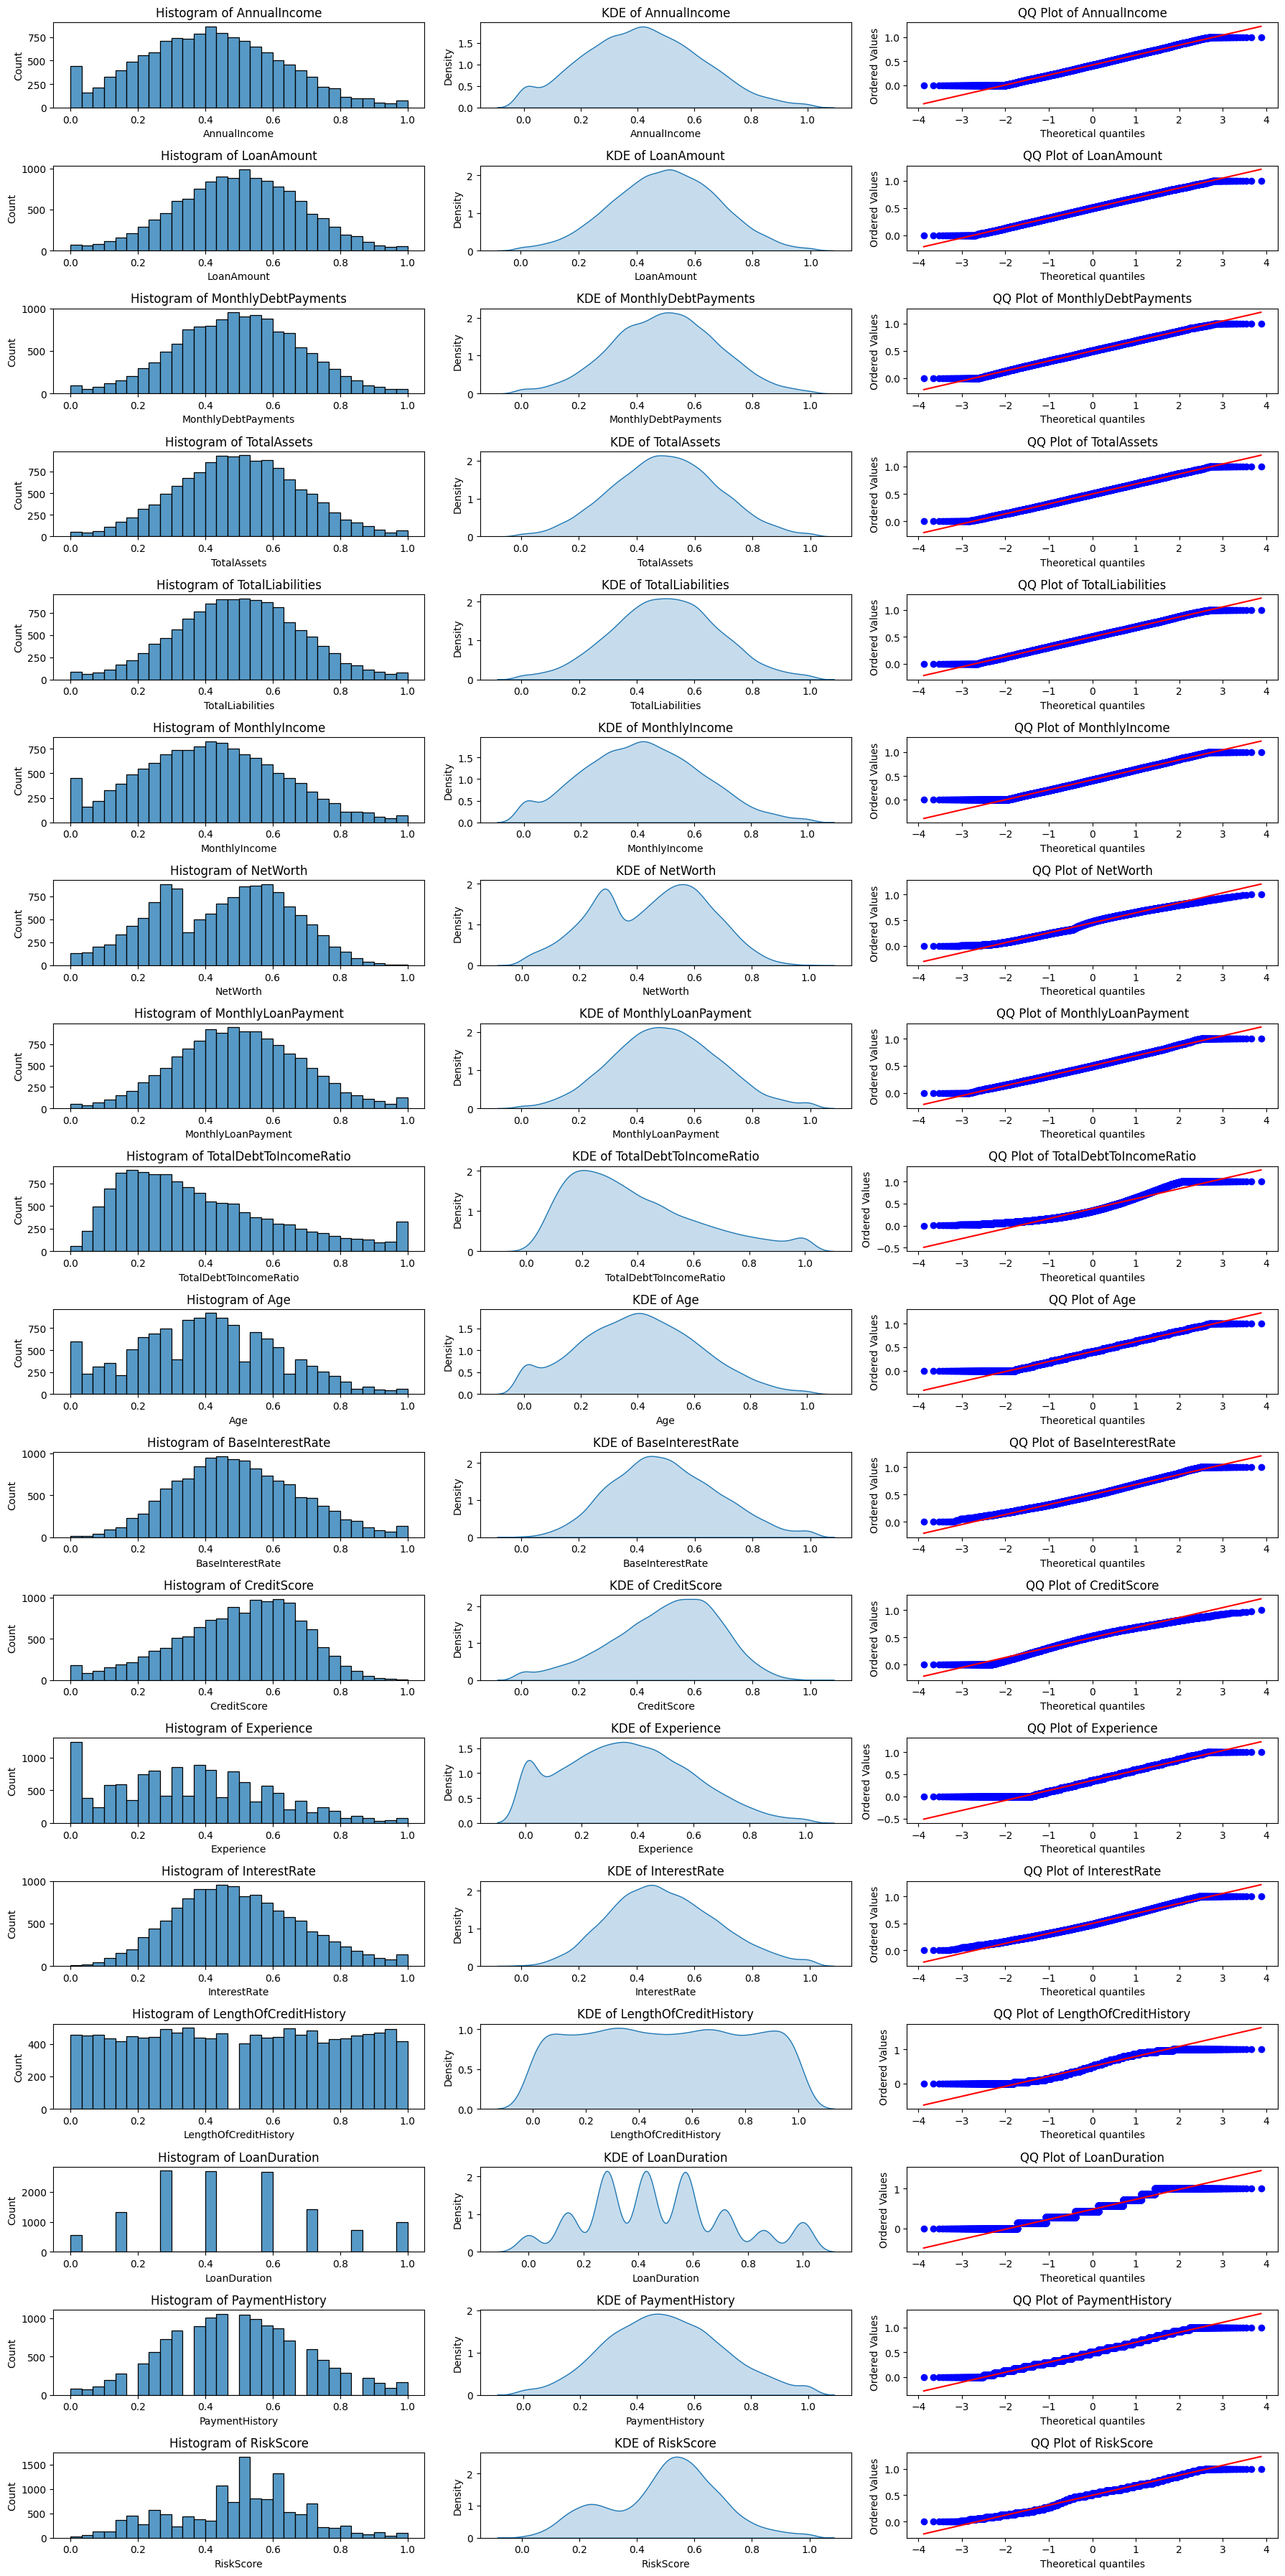

In [42]:
exclude_cols = ['LoanApproved','PreviousLoanDefaults','BankruptcyHistory','EducationLevel_Encoded','HomeOwnershipStatus_Mortgage',
                'HomeOwnershipStatus_Other','HomeOwnershipStatus_Rent','EmploymentStatus_Self-Employed','EmploymentStatus_Unemployed']

def analyze_distribution(X_train):
    continuous_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
    continuous_cols = [col for col in continuous_cols if col not in exclude_cols]

    num_cols = len(continuous_cols)
    num_plots = num_cols * 3  # 3 plots per column
    num_rows = (num_plots // 3) + (num_plots % 3 > 0)  # Calculate rows based on plots

    plt.figure(figsize=(18, num_rows * 2))  # Adjust figure size for better visibility

    for i, col in enumerate(continuous_cols):
        plt.subplot(num_rows, 3, 3 * i + 1)  # Histogram
        sns.histplot(X_train[col], kde=False, bins=30)
        plt.title(f'Histogram of {col}')

        plt.subplot(num_rows, 3, 3 * i + 2)  # KDE plot
        sns.kdeplot(X_train[col], fill=True)
        plt.title(f'KDE of {col}')

        plt.subplot(num_rows, 3, 3 * i + 3)  # QQ plot
        stats.probplot(X_train[col], dist="norm", plot=plt)
        plt.title(f'QQ Plot of {col}')

    plt.tight_layout()
    plt.show()

# Example usage
analyze_distribution(X_train)



*   Histogram: Displays the frequency distribution of the continuous variable,allowing for the identification of the shape and spread of the data.

* KDE Plot: Estimates the probability density function of the variable, providing a smooth curve that represents the distribution and highlighting the underlying data patterns.


*  QQ Plot: Compares the quantiles of the variable's distribution against the quantiles of a normal distribution to assess how closely the data follows a normal distribution.








## Correlation matrix of explanotory variables

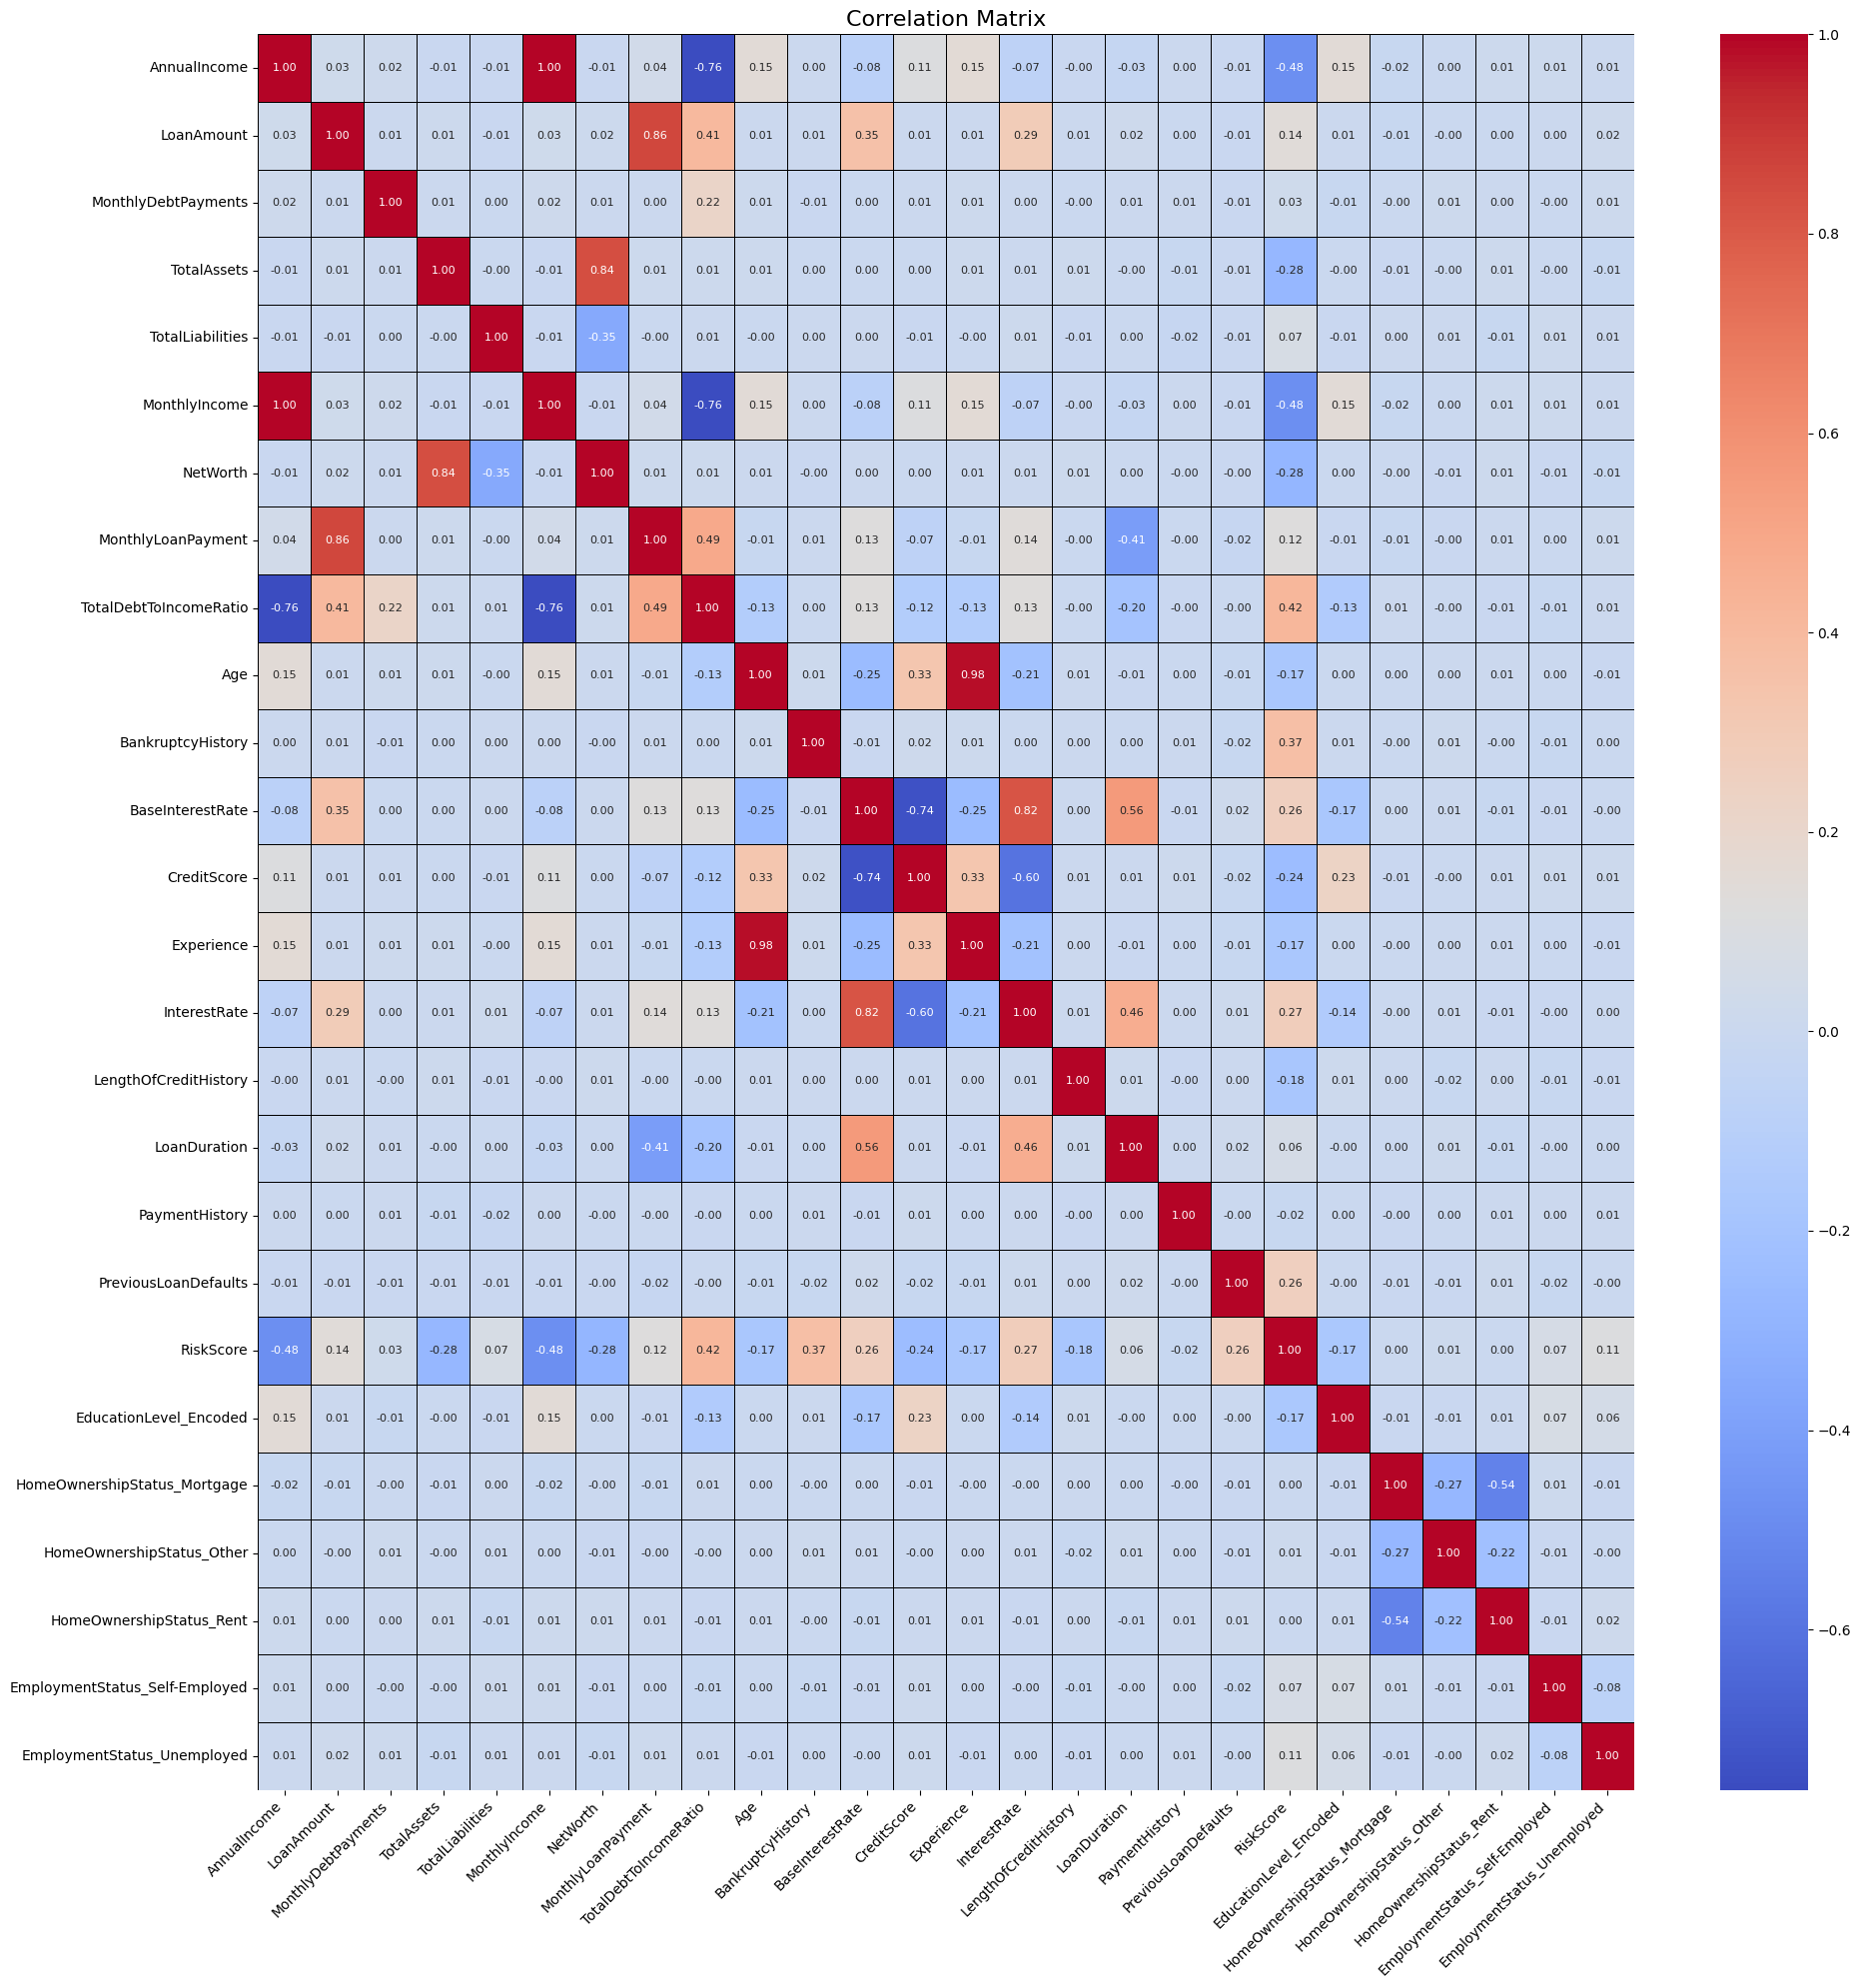

In [43]:
plt.figure(figsize=(20, 20))  # Reduce the figure size slightly to avoid too much blank space
sns.heatmap(X_train.corr(), annot=True, fmt='.2f', cmap='coolwarm',
            annot_kws={"size": 8}, linewidths=0.5, linecolor='black')  # Smaller annotations
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis label size
plt.tight_layout()  # Ensure labels are properly spaced
plt.show()


## Identification of Highly Correlated Variable Pairs in Training Data

In [45]:
import numpy as np
import pandas as pd

# Step 1: Calculate the correlation matrix for numerical columns
correlation_matrix = X_train.corr()

# Step 2: Identify highly correlated pairs (e.g., above 0.8)
# Select the upper triangle of the correlation matrix to avoid duplicate pairs
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Step 3: Find pairs of variables with correlation greater than the threshold (e.g., 0.8)
threshold = 0.8  # You can adjust this value
high_correlation_pairs = upper_triangle.stack().reset_index()
high_correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Filter pairs with absolute correlation above the threshold
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs['Correlation'].abs() > threshold]

# Step 4: Print or display the highly correlated variable pairs with their respective correlations
print(high_correlation_pairs)

           Variable 1          Variable 2  Correlation
4        AnnualIncome       MonthlyIncome     0.995742
30         LoanAmount  MonthlyLoanPayment     0.859889
74        TotalAssets            NetWorth     0.838070
192               Age          Experience     0.982787
222  BaseInterestRate        InterestRate     0.818959


## Scatter plot analysis for high correlated variables

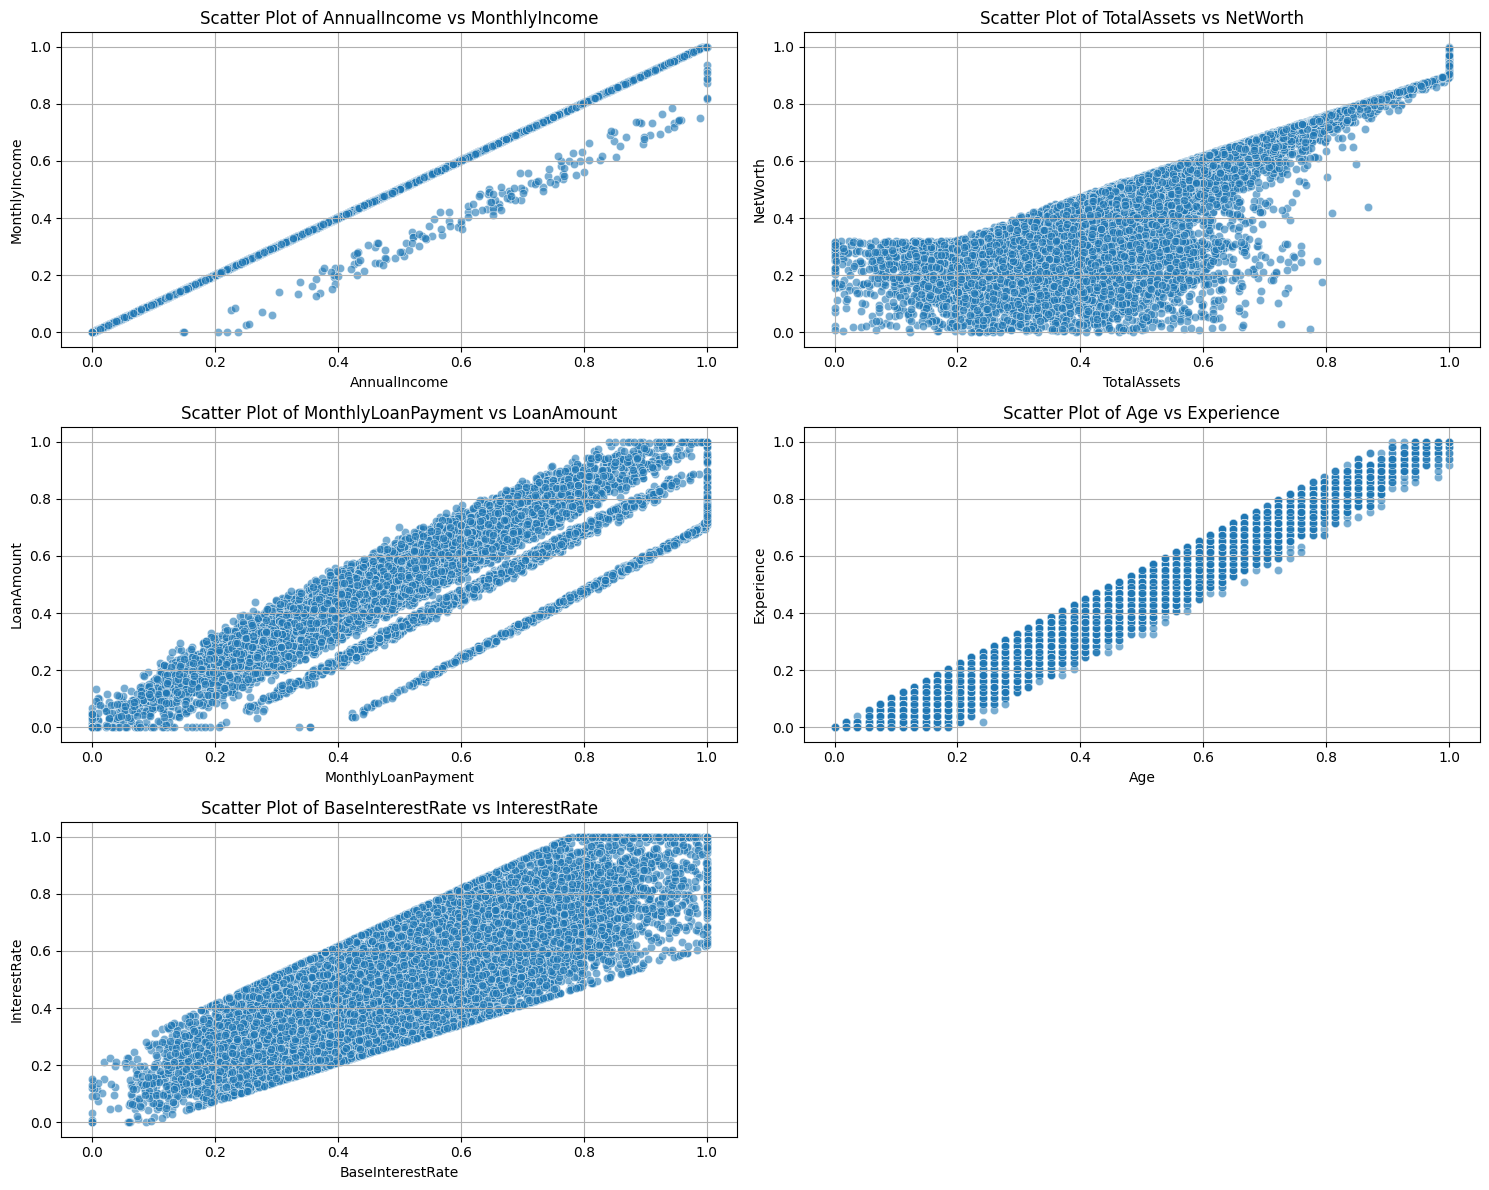

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cleaned_df is already defined

# Define the pairs of variables to plot
correlation_pairs = [
    ('AnnualIncome', 'MonthlyIncome'),
    ('TotalAssets', 'NetWorth'),
    ('MonthlyLoanPayment', 'LoanAmount'),
    ('Age', 'Experience'),
    ('BaseInterestRate', 'InterestRate')
]

# Create scatter plots for each pair
plt.figure(figsize=(15, 12))  # Set figure size for better visibility

for i, (var1, var2) in enumerate(correlation_pairs):
    plt.subplot(3, 2, i + 1)  # Create a subplot for each variable pair
    sns.scatterplot(data=cleaned_df, x=var1, y=var2, alpha=0.6)
    plt.title(f'Scatter Plot of {var1} vs {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


##Adding Interaction Terms and Dropping Original Columns

In [46]:
# Creating interaction terms in the training set
X_train['Experience_Age_interaction'] = X_train['Experience'] * X_train['Age']
X_train['MonthlyIncome_AnnualIncome_interaction'] = X_train['MonthlyIncome'] * X_train['AnnualIncome']
X_train['NetWorth_TotalAssets_interaction'] = X_train['NetWorth'] * X_train['TotalAssets']
X_train['LoanAmount_MonthlyLoanPayment_interaction'] = X_train['LoanAmount'] * X_train['MonthlyLoanPayment']

# Creating interaction terms in the testing set
X_test['Experience_Age_interaction'] = X_test['Experience'] * X_test['Age']
X_test['MonthlyIncome_AnnualIncome_interaction'] = X_test['MonthlyIncome'] * X_test['AnnualIncome']
X_test['NetWorth_TotalAssets_interaction'] = X_test['NetWorth'] * X_test['TotalAssets']
X_test['LoanAmount_MonthlyLoanPayment_interaction'] = X_test['LoanAmount'] * X_test['MonthlyLoanPayment']


# Dropping original columns in the training set
X_train = X_train.drop(columns=['Experience', 'Age', 'MonthlyIncome', 'AnnualIncome', 'NetWorth', 'TotalAssets', 'BaseInterestRate','LoanAmount','MonthlyLoanPayment'])

# Dropping original columns in the testing set
X_test = X_test.drop(columns=['Experience', 'Age', 'MonthlyIncome', 'AnnualIncome', 'NetWorth', 'TotalAssets', 'BaseInterestRate','LoanAmount','MonthlyLoanPayment'])

# Verifying the shape of the cleaned datasets
print("Training set shape after adding interactions and dropping columns:", X_train.shape)
print("Testing set shape after adding interactions and dropping columns:", X_test.shape)

Training set shape after adding interactions and dropping columns: (13053, 21)
Testing set shape after adding interactions and dropping columns: (5595, 21)


In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13053 entries, 4191 to 15795
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   MonthlyDebtPayments                        13053 non-null  float64
 1   TotalLiabilities                           13053 non-null  float64
 2   TotalDebtToIncomeRatio                     13053 non-null  float64
 3   BankruptcyHistory                          13053 non-null  int64  
 4   CreditScore                                13053 non-null  float64
 5   InterestRate                               13053 non-null  float64
 6   LengthOfCreditHistory                      13053 non-null  float64
 7   LoanDuration                               13053 non-null  float64
 8   PaymentHistory                             13053 non-null  float64
 9   PreviousLoanDefaults                       13053 non-null  int64  
 10  RiskScore               

## Significance Assessment of Interaction Features using p values

In [48]:
import pandas as pd
import statsmodels.api as sm

# List of interaction features
interaction_features = [
    'Experience_Age_interaction',
    'MonthlyIncome_AnnualIncome_interaction',
    'NetWorth_TotalAssets_interaction',
    'LoanAmount_MonthlyLoanPayment_interaction'
]

# Create a DataFrame to store the p-values
p_values = {}

# Loop through each interaction feature to calculate p-value
for feature in interaction_features:
    # Create a DataFrame with the interaction feature and the target variable
    X = sm.add_constant(X_train[[feature]])  # Adding a constant for the intercept
    model = sm.Logit(y_train, X)  # Logistic regression
    result = model.fit(disp=0)  # Fit the model without output

    # Store the p-value
    p_values[feature] = result.pvalues[feature]

# Convert p-values to a DataFrame for easier viewing
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'p-value'])

# Display the p-values DataFrame
print(p_values_df)


                                     Feature        p-value
0                 Experience_Age_interaction   9.082478e-42
1     MonthlyIncome_AnnualIncome_interaction   0.000000e+00
2           NetWorth_TotalAssets_interaction   1.026500e-70
3  LoanAmount_MonthlyLoanPayment_interaction  5.313580e-152


## **Handling Class imbalance**

## Checking the class imbalance of Target variable

Class distribution:
 LoanApproved
0    9856
1    3197
Name: count, dtype: int64


<ipython-input-49-6c5a4652f6f4>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


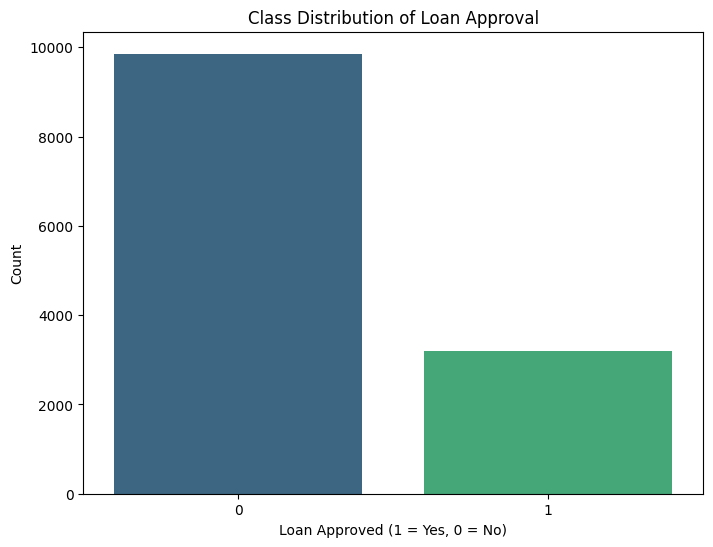

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_train' is your target variable for the training set
class_distribution = y_train.value_counts()

# Display the class distribution
print("Class distribution:\n", class_distribution)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Loan Approval')
plt.xlabel('Loan Approved (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


## Applying SMOTE for Class Imbalance

In [50]:
from imblearn.over_sampling import SMOTE
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the counts of each class in the resampled data
print("Original class distribution:", y_train.value_counts())
print("Resampled class distribution:", y_train_resampled.value_counts())

Original class distribution: LoanApproved
0    9856
1    3197
Name: count, dtype: int64
Resampled class distribution: LoanApproved
0    9856
1    9856
Name: count, dtype: int64


<ipython-input-51-65df0e90232e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_counts.index, y=original_counts.values, palette='viridis', ax=axes[0])
<ipython-input-51-65df0e90232e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resampled_counts.index, y=resampled_counts.values, palette='viridis', ax=axes[1])


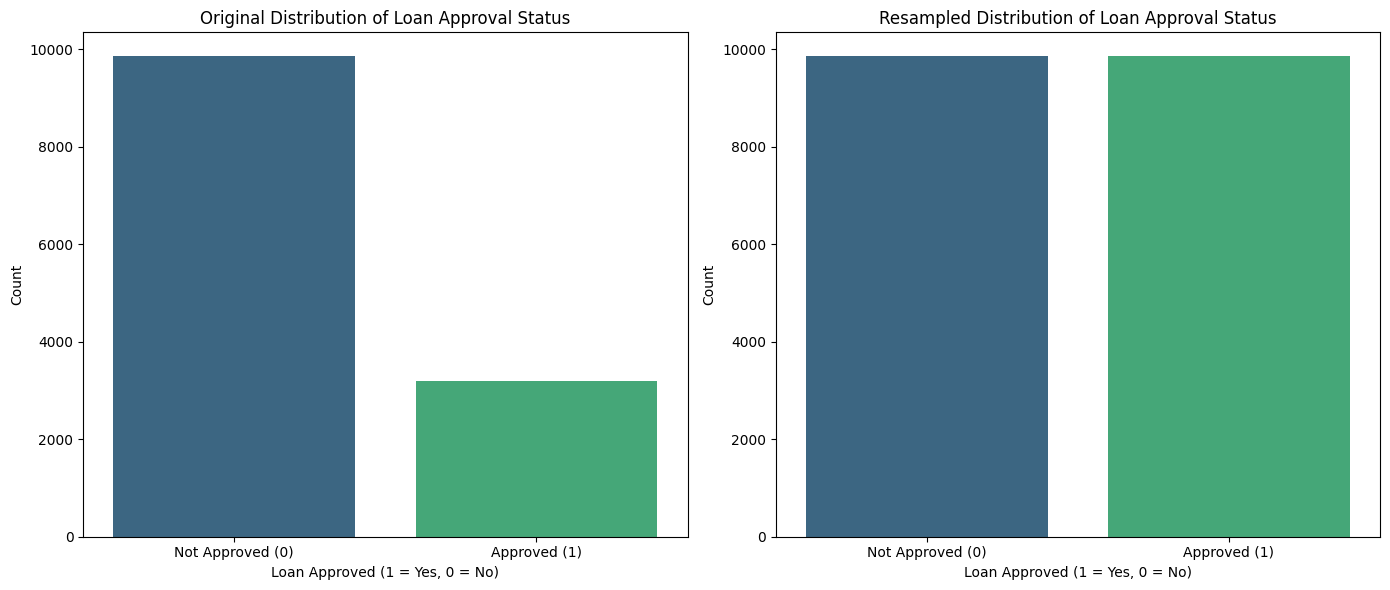

In [51]:
original_counts = y_train.value_counts()
resampled_counts = pd.Series(y_train_resampled).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


# Original distribution
sns.barplot(x=original_counts.index, y=original_counts.values, palette='viridis', ax=axes[0])
axes[0].set_title('Original Distribution of Loan Approval Status')
axes[0].set_xlabel('Loan Approved (1 = Yes, 0 = No)')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Approved (0)', 'Approved (1)'])

# Resampled distribution
sns.barplot(x=resampled_counts.index, y=resampled_counts.values, palette='viridis', ax=axes[1])
axes[1].set_title('Resampled Distribution of Loan Approval Status')
axes[1].set_xlabel('Loan Approved (1 = Yes, 0 = No)')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Not Approved (0)', 'Approved (1)'])

plt.tight_layout()
plt.show()

# **Initialize the models and model training**

In [52]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier  

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)

# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the models
gb_model.fit(X_train_resampled, y_train_resampled)
xgb_model.fit(X_train_resampled, y_train_resampled)
rf_model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

## **Classification report**

In [53]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions
gb_predictions = gb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)


# Evaluate Gradient Boosting
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_predictions))
gb_accuracy = accuracy_score(y_test, gb_predictions) * 100
print(f"Gradient Boosting Model Accuracy: {gb_accuracy:.2f}%")

# Evaluate Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))
rf_accuracy = accuracy_score(y_test, rf_predictions) * 100
print(f"Random Forest Model Accuracy: {rf_accuracy:.2f}%")

# Evaluate XGBoost
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))
xgb_accuracy = accuracy_score(y_test, xgb_predictions) * 100
print(f"XGBoost Model Accuracy: {xgb_accuracy:.2f}%")



Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4169
           1       0.99      0.99      0.99      1426

    accuracy                           0.99      5595
   macro avg       0.99      0.99      0.99      5595
weighted avg       0.99      0.99      0.99      5595

Gradient Boosting Model Accuracy: 99.48%

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4169
           1       0.98      0.98      0.98      1426

    accuracy                           0.99      5595
   macro avg       0.99      0.99      0.99      5595
weighted avg       0.99      0.99      0.99      5595

Random Forest Model Accuracy: 98.98%

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4169
           1       0.99      0.99      0.99     

## **Confusion matrix & ROC Curves**

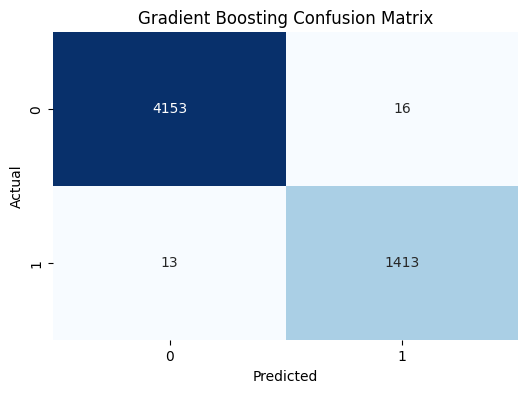

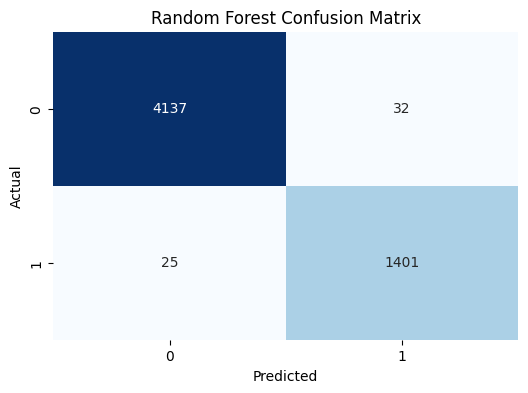

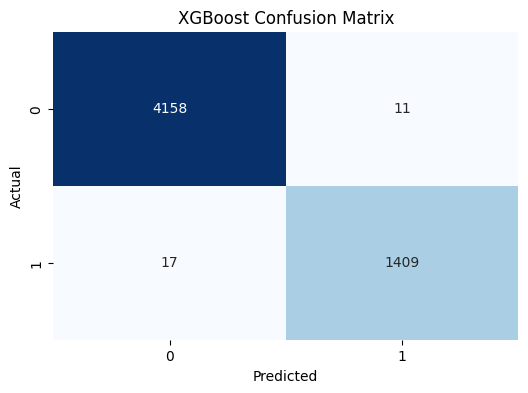

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Generate and plot confusion matrices for each model
gb_cm = confusion_matrix(y_test, gb_model.predict(X_test))
plot_confusion_matrix(gb_cm, "Gradient Boosting")

rf_cm = confusion_matrix(y_test, rf_model.predict(X_test))
plot_confusion_matrix(rf_cm, "Random Forest")

xgb_cm = confusion_matrix(y_test, xgb_model.predict(X_test))
plot_confusion_matrix(xgb_cm, "XGBoost")




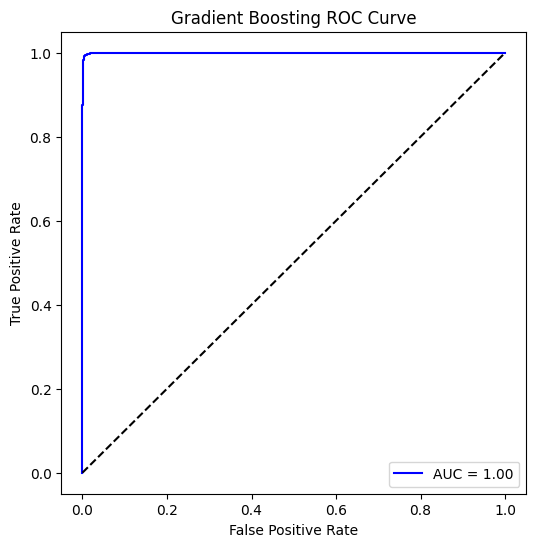

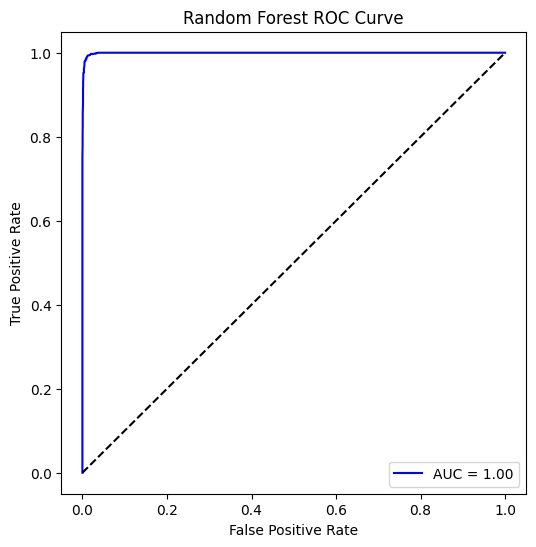

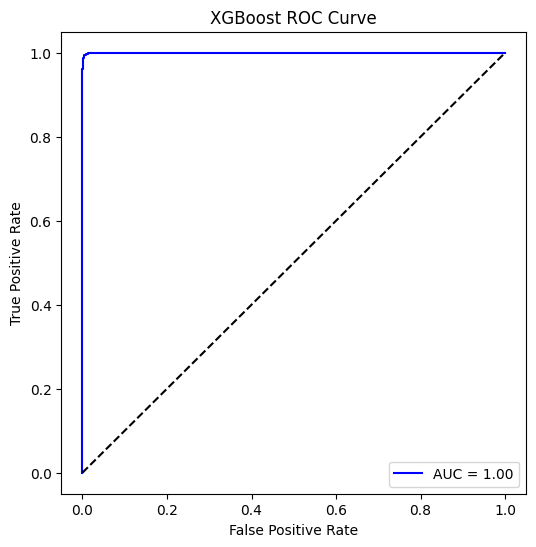

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot ROC curve for a model
def plot_single_roc_curve(y_test, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='b')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line for reference
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Plotting ROC curves individually
# Gradient Boosting
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]
plot_single_roc_curve(y_test, gb_pred_proba, "Gradient Boosting")

# Random Forest
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
plot_single_roc_curve(y_test, rf_pred_proba, "Random Forest")

# XGBoost
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
plot_single_roc_curve(y_test, xgb_pred_proba, "XGBoost")




# **Hyper Parameter Tuning for XGBoost**

In [56]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)

# Define the parameter grid for tuning
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                                scoring='accuracy', cv=5, verbose=1)

# Fit the model
grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


# **Cross Validation**

In [58]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# Define the model with the best parameters from the previous tuning
xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.2,
    max_depth=3,
    min_child_weight=1,
    n_estimators=200,
    subsample=1.0,
    random_state=42
)

# Initialize StratifiedKFold for 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate accuracy on each fold
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Average accuracy:", cv_scores.mean())

Cross-validation scores: [0.99797109 0.99847832 0.99771689 0.99847793 0.99923896]
Average accuracy: 0.9983766387922877
